# Import libraries

In [2]:
# Suppress memory leak warning
import os
os.environ["OMP_NUM_THREADS"] = "1"

# API request
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# File type handling and text preprocessing
import json
from lxml import etree
import ftfy
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# Cache
import pickle

# Data analysis
import numpy as np
import pandas as pd
from IPython.display import HTML
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_blobs

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline

# Project description

This unsupervised machine learning project uses Latent Semantic Analysis and K-means clustering to discover policy themes in President Trump's executive actions. The model output is helpful for quickly characterizing the White House's policy objectives without having to manually review each executive action.

# The theory behind K-means clustering

K-means clustering is an unsupervised machine learning algorithm used to partition observations in a dataset into groups based on feature similarity. In contrast to supervised classification tasks where models can be trained using known class labels, K-means clustering must discover hidden structures in the dataset when the class labels are unknown or unavailable. Through an iterative learning process, K-means clustering aims to group similar observations together while separating dissimilar observations as much as possible. K-means clustering has many practical applications such as customer segmentation, fraud detection, and document topic labeling.

Conceptually, K-means clustering works by:

1. Selecting the number of clusters to group the observations into
2. Initializing the locations of cluster centers in the feature space
3. Assigning observations to the closest cluster center based on a measure of similarity
4. Updating each cluster center's location as the average of all assigned observations
5. Repeating steps 3 and 4 until one of the stopping criteria is met:
   * Observations no longer change cluster assignment
   * Maximum number of iterations is reached

Let's begin by walking through some procedural code that outlines the steps of K-means clustering. Visualizations are generated at each step for intuition and understanding.

In [8]:
# Generate three synthetic data clusters with a total of 100 datapoints
X, y, centers = make_blobs(centers = 3, random_state = 1, return_centers = True)

In [9]:
# Coordinates of synthetic datapoints in 2-D space
X

array([[-7.94152277e-01,  2.10495117e+00],
       [-9.15155186e+00, -4.81286449e+00],
       [-1.14418263e+01, -4.45781441e+00],
       [-9.76761777e+00, -3.19133737e+00],
       [-4.53655648e+00, -8.40186288e+00],
       [-6.26302115e+00, -8.10666081e+00],
       [-6.38481234e+00, -8.47302970e+00],
       [-9.20490564e+00, -4.57687928e+00],
       [-2.76017908e+00,  5.55121358e+00],
       [-1.17104176e+00,  4.33091816e+00],
       [-1.00364080e+01, -5.56912090e+00],
       [-9.87589123e+00, -2.82386464e+00],
       [-7.17532921e+00, -8.77059017e+00],
       [-2.40671820e+00,  6.09894447e+00],
       [-4.87418245e+00, -1.00495890e+01],
       [-6.07854700e+00, -7.93969420e+00],
       [-6.83238762e+00, -7.47067670e+00],
       [-2.34673261e+00,  3.56128423e+00],
       [-1.03415662e+01, -3.90975169e+00],
       [-1.10926243e+01, -3.78396611e+00],
       [-6.50212109e+00, -7.91249101e+00],
       [-1.02639310e+01, -3.92073400e+00],
       [-6.81608302e+00, -8.44986926e+00],
       [-1.

In [10]:
# Cluster assignments
y

array([0, 1, 1, 1, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 2, 2, 2, 0, 1, 1, 2, 1,
       2, 0, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1,
       1, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 1, 2,
       0, 2, 0, 1, 1, 1, 2, 0, 0, 1, 2, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0,
       1, 0, 2, 0, 0, 1, 1, 2, 2, 0, 2, 0])

In [11]:
# Coordinates of cluster centers in 2-D space
centers

array([[-1.65955991,  4.40648987],
       [-9.9977125 , -3.95334855],
       [-7.06488218, -8.1532281 ]])

In [12]:
# X is a 2-D array whereas y is a 1-D array. Reshape y to 2-D array to stack horizontally with X.
y = y.reshape((len(X), -1)) + 1 ## Add 1 to all cluster assignments to range from 1 to 3
y

array([[1],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [2],
       [1],
       [1],
       [2],
       [2],
       [3],
       [1],
       [3],
       [3],
       [3],
       [1],
       [2],
       [2],
       [3],
       [2],
       [3],
       [1],
       [2],
       [3],
       [3],
       [1],
       [1],
       [3],
       [1],
       [1],
       [3],
       [1],
       [2],
       [3],
       [2],
       [2],
       [2],
       [3],
       [3],
       [2],
       [1],
       [2],
       [2],
       [3],
       [1],
       [1],
       [1],
       [1],
       [2],
       [3],
       [3],
       [3],
       [1],
       [3],
       [2],
       [2],
       [1],
       [1],
       [2],
       [3],
       [3],
       [2],
       [2],
       [3],
       [1],
       [3],
       [1],
       [2],
       [2],
       [2],
       [3],
       [1],
       [1],
       [2],
       [3],
       [3],
       [1],
       [2],
       [1],
       [2],
       [2],
    

In [13]:
y.shape

(100, 1)

In [14]:
# Horizontally stack cluster assignment array with coordinates array
data = np.hstack(tup = (X, y))

# Turn stacked array into dataframe for easy viewing
data = pd.DataFrame(data = data, columns = ['X_1', 'X_2', 'y'])

# Convert cluster assignments from float to integer
data['Cluster'] = data['y'].astype(int)

# Show dataframe
data

,X_1,X_2,y,Cluster
0,-0.794152,2.104951,1.0,1
1,-9.151552,-4.812864,2.0,2
2,-11.441826,-4.457814,2.0,2
3,-9.767618,-3.191337,2.0,2
4,-4.536556,-8.401863,3.0,3
...,...,...,...,...
95,-6.026058,-5.966248,3.0,3
96,-7.047473,-9.275247,3.0,3
97,-1.373973,5.291631,1.0,1
98,-6.253931,-7.108786,3.0,3


The plots below visualize the three-cluster synthetic dataset with and without the cluster assignments. The right-side plot simulates real-life scenarios where the cluster assignments are unknown or unavailable. The objective of K-means clustering is to identify three clusters that match the true cluster assignments shown by the left-side plot.

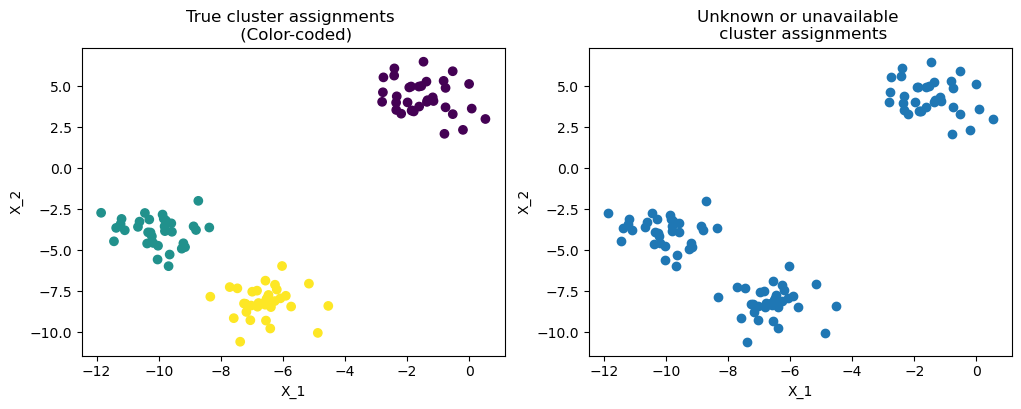

In [16]:
# Instantiate figure and axes objects
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

# Define datapoint coordinates and true cluster assignments
coordinates = data.loc[:, ['X_1', 'X_2']]
cluster_assigns = data['y']

# Plot dataset side by side with and without the true cluster assignments
axes[0].scatter(x = coordinates['X_1'], y = coordinates['X_2'], c = cluster_assigns)
axes[1].scatter(x = coordinates['X_1'], y = coordinates['X_2'])

# Format subplots
axes[0].set_title('True cluster assignments \n (Color-coded)')
axes[1].set_title('Unknown or unavailable \n cluster assignments')

# Shared format
for ax in axes:
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')

## Select the number of clusters

The first step is to select the number of clusters to group the observations into. While this simple 2-D example makes it easy for a human to guess that there are three clusters based on visual inspection, note that there is often no way to know in advance what the best number of clusters is because the true clusters may not be clearly separated in the feature space. Further, as the feature dimensions increase beyond 3-D, visual detection of potential clusters becomes impossible. Some techniques for discovering the optimal number of clusters are discussed in later sections.

For now, let's set the number of clusters to three for illustration. 

## Initialize cluster centers randomly

In the plot below, three random observations from the dataset are selected as the initial cluster centers.

In [21]:
# Initialize cluster centers by selecting three random rows from the dataset
k = 3
rng = np.random.default_rng(seed = 10)  ## Random seed for reproducibility
center_idx = rng.permutation(coordinates.shape[0])[: k]
print(f'Row indices initial cluster centers (k=3): {center_idx}')

## Retrieve the coordinates of the initial cluster centers 
initial_centers = coordinates.iloc[center_idx]
initial_centers

Row indices initial cluster centers (k=3): [73 37 79]


,X_1,X_2
73,-0.820576,5.337592
37,-11.370830,-3.638189
79,-10.444841,-2.728841


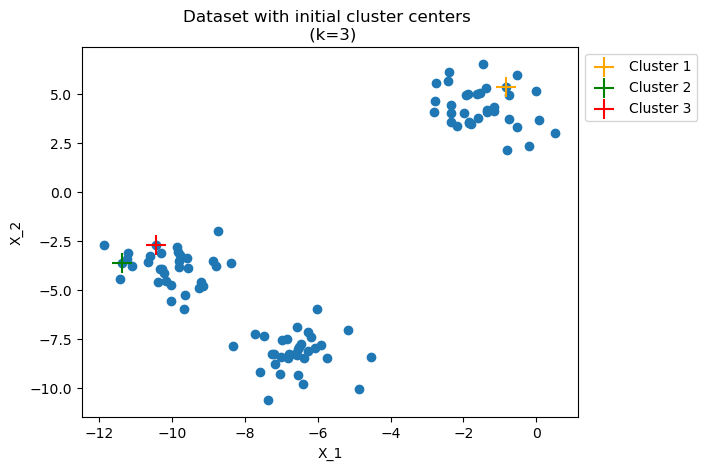

In [22]:
# Plot dataset
plt.scatter(x = coordinates['X_1'], y = coordinates['X_2'])

# Set alternating color list
colors = ['orange', 'green', 'red']

# Plot initial cluster centers
for center in range(k):
    plt.scatter(x = initial_centers.loc[center_idx[center], 'X_1'], 
                y = initial_centers.loc[center_idx[center], ['X_2']], 
                c = colors[center], 
                s = 200, 
                marker = '+', 
                label = f'Cluster {center + 1}')

# Format plot
plt.title('Dataset with initial cluster centers \n (k=3)')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1));

## Cluster assignments

Once the cluster centers are initialized, datapoints are assigned to the closest cluster center based on a measure of similarity. For this example, the Euclidean distances between each of the datapoints and the three cluster centers are used to determine which cluster center is closest to a datapoint in the feature space. The code cell below calculates these Euclidean distances for sample datapoint [-6.026058, -5.966248] (row index 95), which is assigned to cluster 3.

In [25]:
# Retrieve sample datapoint
sample_data = coordinates.iloc[95]
print(f'Sample datapoint:\n{sample_data}\n')

# Calculate Euclidean distances between each cluster center and sample datapoint
cluster_dict = {}
for center in range(k):
    l2_dist = np.linalg.norm(initial_centers.iloc[center] - sample_data)
    cluster_dict[center + 1] = l2_dist
    print(f'Distance to cluster {center + 1}: {l2_dist}\n')

Sample datapoint:
X_1   -6.026058
X_2   -5.966248
Name: 95, dtype: float64

Distance to cluster 1: 12.44483191290306

Distance to cluster 2: 5.829789913461637

Distance to cluster 3: 5.477814853394134



Closest cluster center: 3, Distance: 5.477814853394134



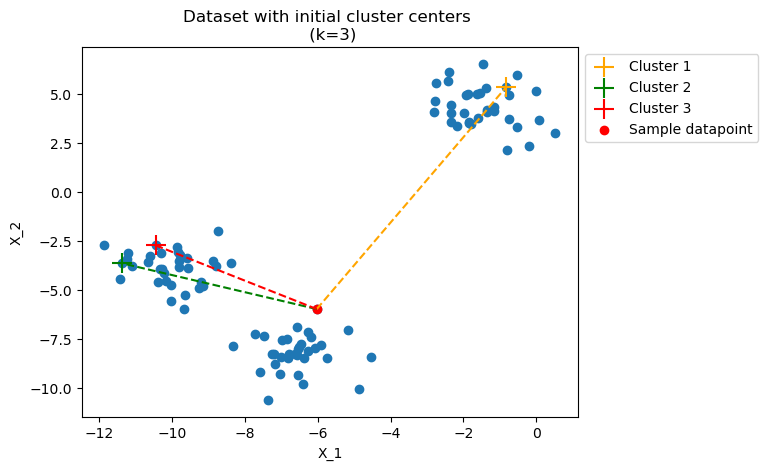

In [26]:
# Retrieve the closest cluster and distance
cluster_assign = min(cluster_dict, key = cluster_dict.get)
min_dist = cluster_dict[cluster_assign]
print(f'Closest cluster center: {cluster_assign}, Distance: {min_dist}\n')

# Plot dataset
plt.scatter(x = coordinates['X_1'], y = coordinates['X_2'])

# Set alternating color list
colors = ['orange', 'green', 'red']

# Plot initial cluster centers
for center in range(k):
    plt.scatter(x = initial_centers.loc[center_idx[center], 'X_1'], 
                y = initial_centers.loc[center_idx[center], ['X_2']], 
                c = colors[center], 
                s = 200, 
                marker = '+', 
                label = f'Cluster {center + 1}')

# Plot the sample datapoint
plt.scatter(x = sample_data.iloc[0], 
            y = sample_data.iloc[1], 
            c = 'red', 
            label = 'Sample datapoint')

# Plot distances between each cluster center and sample datapoint
for center in range(k):
    plt.plot([sample_data.iloc[0], initial_centers.loc[center_idx[center], 'X_1']], 
             [sample_data.iloc[1], initial_centers.loc[center_idx[center], 'X_2']],
             c = colors[center], 
             linestyle = '--')

# Format plot
plt.title('Dataset with initial cluster centers \n (k=3)')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1));

This process is replicated for the remaining datapoints in the dataset. The code cell below shows all the cluster center assignments after one iteration.

In [28]:
# Use loop to obtain all cluster assignments for one iteration
n_obs = coordinates.shape[0]
cluster_list = [] # Initialize empty list to append cluster assignments

for obs in range(n_obs):
    distance = np.linalg.norm(x = initial_centers - coordinates.iloc[obs], axis = 1)
    cluster_iter = np.argmin(distance) + 1
    cluster_list.append(cluster_iter)
    print(f'{obs}. Closest cluster center: {cluster_iter}, Distance: {min(distance)}')

0. Closest cluster center: 1, Distance: 3.232748774640426
1. Closest cluster center: 3, Distance: 2.452702905451747
2. Closest cluster center: 2, Distance: 0.8226943901131684
3. Closest cluster center: 3, Distance: 0.8200819675100275
4. Closest cluster center: 3, Distance: 8.190909954275128
5. Closest cluster center: 2, Distance: 6.786526970817008
6. Closest cluster center: 2, Distance: 6.945218026714549
7. Closest cluster center: 3, Distance: 2.225463081619935
8. Closest cluster center: 1, Distance: 1.9513309333712348
9. Closest cluster center: 1, Distance: 1.0659352849913135
10. Closest cluster center: 2, Distance: 2.3471640292512554
11. Closest cluster center: 3, Distance: 0.5768305102950452
12. Closest cluster center: 2, Distance: 6.629009395000641
13. Closest cluster center: 1, Distance: 1.7594042105096288
14. Closest cluster center: 2, Distance: 9.127566782065163
15. Closest cluster center: 3, Distance: 6.798346613367483
16. Closest cluster center: 2, Distance: 5.940153058670411


In [29]:
# Cluster center assignments after one iteration
cluster_array = np.array(cluster_list)
cluster_array

array([1, 3, 2, 3, 3, 2, 2, 3, 1, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 3, 2, 2, 2, 2, 2, 1, 2,
       3, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 3, 3, 1, 1, 3, 2, 3, 2, 2, 3,
       1, 2, 1, 3, 3, 2, 2, 1, 1, 2, 3, 2, 1, 3, 1, 2, 3, 3, 1, 1, 1, 1,
       3, 1, 3, 1, 1, 2, 3, 3, 2, 1, 3, 1], dtype=int64)

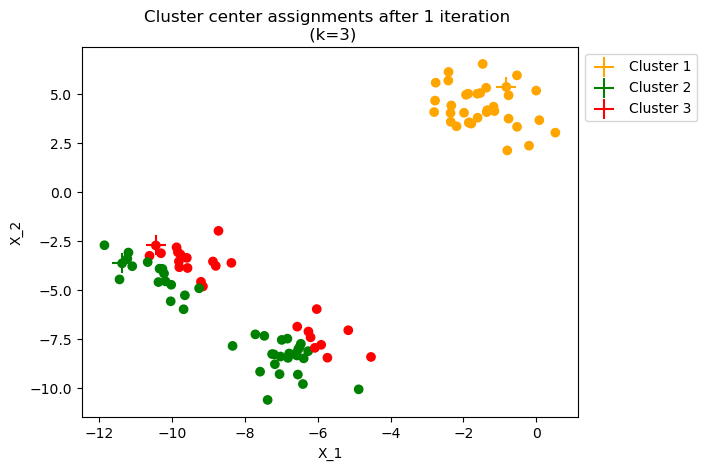

In [30]:
# Set alternating color list
colors = ['orange', 'green', 'red']

# Adjust cluster_array so that cluster assignment number matches index position of colors list
cluster_colors = np.array(colors)[cluster_array - 1]

# Plot cluster assignment after 1 iteration
plt.scatter(x = coordinates['X_1'], y = coordinates['X_2'], c = cluster_colors)

# Plot initial cluster centers
for center in range(k):
    plt.scatter(x = initial_centers.loc[center_idx[center], 'X_1'], 
                y = initial_centers.loc[center_idx[center], ['X_2']], 
                c = colors[center], 
                s = 200, 
                marker = '+', 
                label = f'Cluster {center + 1}')

# Format plot
plt.title('Cluster center assignments after 1 iteration \n (k=3)')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1));

### Update cluster centers

After each iteration of cluster center assignment, cluster centers are updated as the average coordinates of all assigned datapoints.

In [33]:
# Create dataframe showing cluster assignments after one iteration
cluster_table = coordinates.copy()
cluster_table['Cluster'] = cluster_array.reshape(len(cluster_array), -1)  ## Match dimensions of new column with coordinates matrix
cluster_table

,X_1,X_2,Cluster
0,-0.794152,2.104951,1
1,-9.151552,-4.812864,3
2,-11.441826,-4.457814,2
3,-9.767618,-3.191337,3
4,-4.536556,-8.401863,3
...,...,...,...
95,-6.026058,-5.966248,3
96,-7.047473,-9.275247,2
97,-1.373973,5.291631,1
98,-6.253931,-7.108786,3


In [34]:
# Exclude initial cluster centers for the first update
cluster_table_mask = cluster_table.drop(index = center_idx)

# Calculate new cluster centers without initial cluster centers for the first update
new_centers = cluster_table_mask.groupby('Cluster').mean()
new_centers

,X_1,X_2
Cluster,,
1,-1.490794,4.306904
2,-8.306488,-6.783762
3,-8.114932,-4.972346


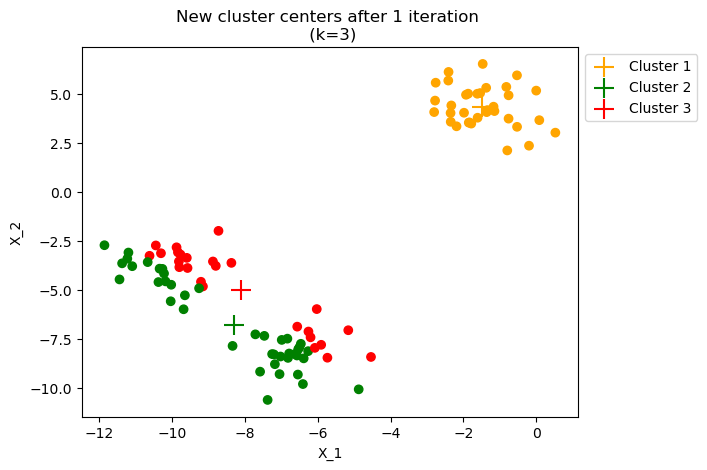

In [35]:
# Set alternating color list
colors = ['orange', 'green', 'red']

# Adjust cluster_array so that cluster assignment number matches index position of colors list
cluster_colors = np.array(colors)[cluster_array - 1]

# Plot cluster assignment after 1 iteration
plt.scatter(x = coordinates['X_1'], y = coordinates['X_2'], c = cluster_colors)

# Plot new cluster centers
for center in range(k):
    plt.scatter(x = new_centers.loc[center + 1, 'X_1'], 
                y = new_centers.loc[center + 1, 'X_2'], 
                c = colors[center], 
                s = 200, 
                marker = '+', 
                label = f'Cluster {center + 1}')

# Format plot
plt.title('New cluster centers after 1 iteration \n (k=3)')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1));

The plot above shows how the cluster centers are updated after one iteration of cluster assignments. The iterative process of reassigning datapoints to the revised cluster centers and then recalculating new cluster centers continues until datapoints no longer change cluster assignments or when the maximum number of iterations is reached.

## Smart initial cluster centers via K-means++

One potential weakness of randomly initializing cluster centers is that datapoints close to each other may end up becoming the initial cluster centers by chance. This can lead to suboptimal results where the K-means clustering algorithm fails to identify the true clusters. An alternative method called K-means++ improves upon random cluster center initialization by increasing the probability that a datapoint further away from an existing initial cluster center will be selected as the next initial cluster center.    

Previously, a for-loop was used to make the Euclidean distance calculations between each cluster center and each datapoint easy to understand. However, this sort of iterative programming approach can quicly become computationally inefficient as the dataset grows in size. The code cell below shows how to use vectorized operation to simultaneously calculate the distances between the cluster centers and the datapoints more efficiently.

In [39]:
# Setup for smart cluster center selections
smart_centers_idx = []
rng_first = np.random.default_rng(seed = 2)
rng_selection = np.random.default_rng(seed = 45)

# Select first smart cluster center randomly from amongst the datapoints
smart_center_1 = rng_first.choice(a = coordinates.index, size = 1).item()  # Set type as integer instead of array
smart_centers_idx.append(smart_center_1)

# Obtain k-1 additional smart cluster centers
for c in range(1, k):
    # Retain all datapoints other than the smart cluster centers as a dataframe for later reference
    smart_centers_not_df = coordinates.drop(index = smart_centers_idx)
    
    # Convert to NumPy arrays to set up vectorized operation
    smart_centers = coordinates.loc[smart_centers_idx].to_numpy()  
    smart_centers_not = smart_centers_not_df.to_numpy()
    
    ## Calculate distance^2 between each datapoint and its closest smart cluster center using vectorized operation
    distance_sq = np.linalg.norm(x = smart_centers[np.newaxis, :, :] - smart_centers_not[:, np.newaxis, :], axis = 2) ** 2
    min_distance_sq = np.min(a = distance_sq, axis = 1)

    ## Calculate each datapoint's probability of being selected as the next smart cluster center
    select_prob = min_distance_sq / np.sum(min_distance_sq)

    ## Probabilistically select next smart cluster center by referencing the index of the retained dataframe
    smart_center_next = rng_selection.choice(a = smart_centers_not_df.index, size = 1, p = select_prob).item()
    smart_centers_idx.append(smart_center_next)

print('K-means++ smart cluster centers:')
coordinates.loc[smart_centers_idx]

K-means++ smart cluster centers:


,X_1,X_2
83,-5.160223,-7.042171
64,-11.855694,-2.717185
59,-1.146630,4.108397


The plot below shows that K-means++ smart initialization chooses cluster centers that are far away from each other in the feature space.

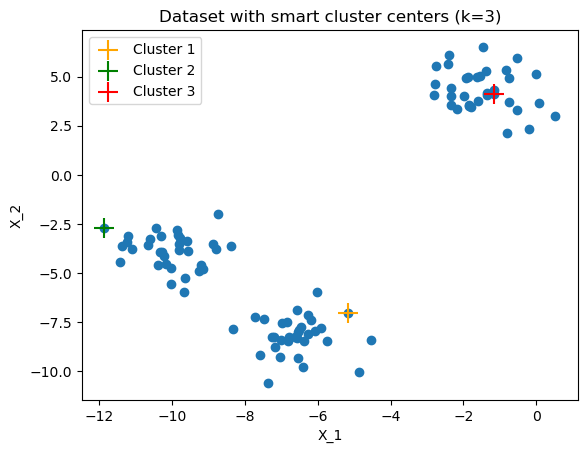

In [41]:
# Plot dataset
plt.scatter(x = coordinates['X_1'], y = coordinates['X_2'])

# Set alternating color list
colors = ['orange', 'green', 'red']

# Plot K-means++ smart cluster centers
for center in range(k):
    plt.scatter(x = coordinates.loc[smart_centers_idx[center], 'X_1'], 
                y = coordinates.loc[smart_centers_idx[center], ['X_2']], 
                c = colors[center], s = 200, marker = '+', label = f'Cluster {center + 1}')

# Format plot
plt.title('Dataset with smart cluster centers (k=3)')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.legend()

# Clean display
plt.show()

# Implementation via object-oriented programming

The code cell below combines the key concepts covered in the preceding sections into a Python class to show how to program the K-means clustering model using object-oriented programming. This implementation is akin to a simplified version of machine learning libraries like scikit-learn.

In [43]:
class K_Means:
    def __init__(self, n_clusters, init_method = 'random', max_iter = 100):
        # Error handling
        if not n_clusters > 1:
            raise ValueError('Number of clusters must be greater than 1')
        if init_method not in ['random', 'smart']:
            raise ValueError('Cluster center initialization method must either be "random" or "smart"')
        if max_iter < 1:
            raise ValueError('Maximum number of iterations must be greater than or equal to 1')
        
        # Define attributes
        self.n_clusters = n_clusters
        self.init_method = init_method
        self.max_iter = max_iter

    
    def random_init(self, data):
        # Format data to setup random cluster center retrieval
        data_array = data.to_numpy()
        n_obs = data_array.shape[0]

        # Error handling
        if self.n_clusters >= n_obs:
            raise ValueError('Number of clusters must be less than the number of observations')

        # Retrieve random cluster centers
        random_centers_idx = np.random.choice(a = n_obs, size = self.n_clusters, replace = False)
        random_centers_idx = list(random_centers_idx)
        
        return random_centers_idx

        
    def smart_init(self, data):
        # Setup for smart cluster center selections
        smart_centers_idx = []
        data_array = data.to_numpy()
        n_obs = data_array.shape[0]

        # Error handling
        if self.n_clusters >= n_obs:
            raise ValueError('Number of clusters must be less than the number of observations')
        
        # Retrieve first random cluster center
        smart_centers_1 = np.random.choice(a = n_obs, size = 1).item()
        smart_centers_idx.append(smart_centers_1)

        # Obtain k-1 additional smart cluster centers
        for c in range(1, self.n_clusters):
            ## Retain all datapoints other than the smart cluster centers as a dataframe for later reference
            smart_centers_not_df = data.drop(index = smart_centers_idx)

            ## Convert to NumPy arrays to set up vectorized operation
            smart_centers = data_array[smart_centers_idx]
            smart_centers_not = smart_centers_not_df.to_numpy()
    
            ## Calculate distance^2 between each datapoint and its closest smart cluster center using vectorized operation
            distance_sq = np.linalg.norm(x = smart_centers[np.newaxis, :, :] - smart_centers_not[:, np.newaxis, :], axis = 2) ** 2
            min_distance_sq = np.min(a = distance_sq, axis = 1)

            ## Calculate each datapoint's probability of being selected as the next smart cluster center
            select_prob = min_distance_sq / np.sum(min_distance_sq)
        
            ## Probabilistically select next smart cluster center by referencing the index of the retained dataframe
            smart_center_next = np.random.choice(a = smart_centers_not_df.index, size = 1, p = select_prob).item()
            smart_centers_idx.append(smart_center_next)

        return smart_centers_idx

    
    def fit(self, data):
        # Retrieve randomly initialized cluster centers
        if self.init_method == 'random':
            init_centers_idx = self.random_init(data)

        # Retrieve smart initialized cluster centers
        elif self.init_method == 'smart':
            init_centers_idx = self.smart_init(data)

        # Initial setup for distance calculations between cluster centers and datapoints
        cluster_centers_df = data.loc[init_centers_idx]
        cluster_centers = cluster_centers_df.to_numpy()
        data_array = data.to_numpy()

        # Initial setup to randomly select previously unused datapoints as new cluster centers if old cluster centers
        # end up with no datapoints assigned
        centers_idx_used = init_centers_idx
        last_centers_idx_used = init_centers_idx
        
        # Iteratively update cluster assignments and cluster centers
        iteration = 0
        old_clusters = np.zeros(shape = (data_array.shape[0], 1))
        
        for i in range(self.max_iter):
            # Calculate the distance between the datapoints and cluster centers using vectorized operation
            dist = np.linalg.norm(x = cluster_centers[np.newaxis, :, :] - data_array[:, np.newaxis, :], axis = 2)
            
            # Assign datapoints to the nearest cluster center
            new_clusters = np.argmin(a = dist, axis = 1) + 1

            # Update cluster centers

            ## Case 1: Cluster centers include datapoints
            if len(last_centers_idx_used) > 0:
                new_clusters_df = pd.DataFrame(data = new_clusters, columns = ['Cluster']) 
                cluster_assign_df = pd.concat(objs = [data, new_clusters_df], axis = 1)
                cluster_centers_not_df = cluster_assign_df.drop(index = last_centers_idx_used)
                cluster_centers_df = cluster_centers_not_df.groupby('Cluster').mean()
                cluster_centers = cluster_centers_df.to_numpy()

            ## Case 2: Cluster centers do not include datapoints
            else:
                new_clusters_df = pd.DataFrame(data = new_clusters, columns = ['Cluster']) 
                cluster_assign_df = pd.concat(objs = [data, new_clusters_df], axis = 1)
                cluster_centers_df = cluster_assign_df.groupby('Cluster').mean()
                cluster_centers = cluster_centers_df.to_numpy()

            # Randomly add previously unused datapoints as supplemental cluster centers if datapoints are 
            # assigned to fewer than self.n_clusters during update
            if len(cluster_centers_df) < self.n_clusters:
                n_add_clusters = self.n_clusters - len(cluster_centers_df)
                eligible_idx = np.delete(arr = data.index, obj = centers_idx_used)
                random_centers_idx = np.random.choice(a = eligible_idx, size = n_add_clusters, replace = False)
                random_centers_df = data.loc[random_centers_idx]

                ## Append random supplemental cluster centers to updated cluster centers table
                n_clusters_idx = np.arange(self.n_clusters) + 1
                n_centers_idx = cluster_centers_df.index
                missing_cluster_idx = np.setdiff1d(n_clusters_idx, n_centers_idx)
                
                random_centers_df.index = missing_cluster_idx
                random_centers_df.index.name = 'Cluster'
                cluster_centers_df = pd.concat(objs = [cluster_centers_df, random_centers_df]).sort_index()
                cluster_centers = cluster_centers_df.to_numpy()
                
                ## Append supplemental cluster center indices for tracking 
                centers_idx_used.extend(random_centers_idx.tolist())
                
                ## Reset last_centers_idx_used to a list containing the row indices of the random supplemental cluster centers
                last_centers_idx_used = list(random_centers_idx)

            else:
                ## Reset last_centers_idx_used to a blank list
                last_centers_idx_used = []

            # Update iteration count
            iteration += 1

            # Check for convergence
            if np.array_equal(old_clusters, new_clusters):
                print(f'Cluster assignment convergence after {iteration} iterations!\n') 
                
                break
                
            else:
                old_clusters = new_clusters

        self.cluster_centers = cluster_centers_df
        self.cluster_assign = cluster_assign_df

        plot_clusters = self.plot_clusters(cluster_centers_df, cluster_assign_df)
        
        return plot_clusters
            

    def plot_clusters(self, cluster_centers, cluster_assign):
        # Plot dataset
        plt.scatter(x = cluster_assign.iloc[:, 0], 
                    y = cluster_assign.iloc[:, 1],
                    c = cluster_assign.iloc[:, 2])
        
        # Plot cluster centers
        plt.scatter(x = cluster_centers.iloc[:, 0], 
                    y = cluster_centers.iloc[:, 1], 
                    c = 'red', s = 200, marker = '+', label = 'Cluster Centers')
        
        # Format plot
        plt.title(f'Cluster Assignments (k={self.n_clusters})')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        
        # Clean display
        plt.show()

Cluster assignment convergence after 2 iterations!



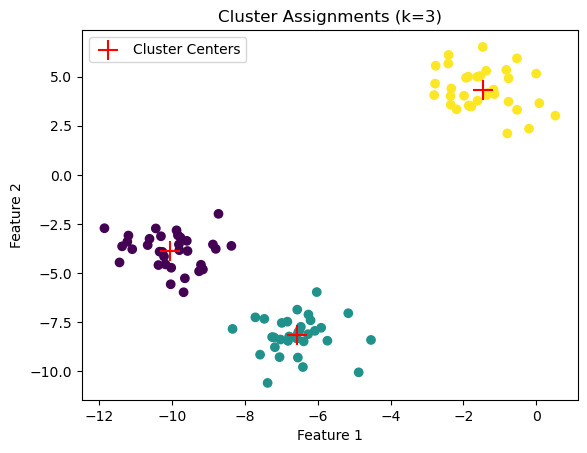

In [44]:
clustering_random = K_Means(n_clusters = 3, init_method = 'random', max_iter = 100)
clustering_random.fit(coordinates)

In [45]:
clustering_random.cluster_centers

,X_1,X_2
Cluster,,
1,-10.049352,-3.859541
2,-6.581968,-8.172393
3,-1.471082,4.337219


In [46]:
clustering_random.cluster_assign

,X_1,X_2,Cluster
0,-0.794152,2.104951,3
1,-9.151552,-4.812864,1
2,-11.441826,-4.457814,1
3,-9.767618,-3.191337,1
4,-4.536556,-8.401863,2
...,...,...,...
95,-6.026058,-5.966248,2
96,-7.047473,-9.275247,2
97,-1.373973,5.291631,3
98,-6.253931,-7.108786,2


Cluster assignment convergence after 2 iterations!



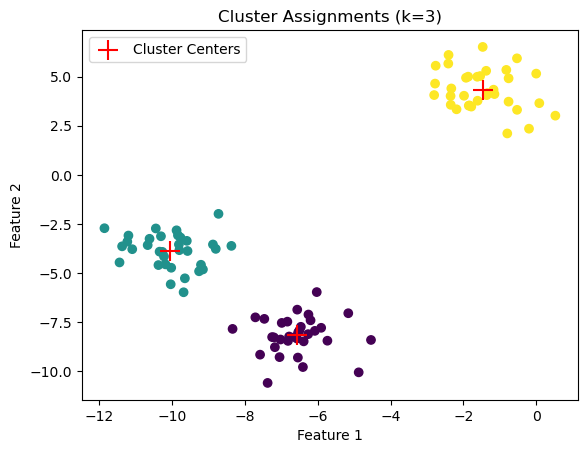

In [47]:
clustering_smart = K_Means(n_clusters = 3, init_method = 'smart', max_iter = 100)
clustering_smart.fit(coordinates)

In [48]:
clustering_smart.cluster_centers

,X_1,X_2
Cluster,,
1,-6.581968,-8.172393
2,-10.049352,-3.859541
3,-1.471082,4.337219


In [49]:
clustering_smart.cluster_assign

,X_1,X_2,Cluster
0,-0.794152,2.104951,3
1,-9.151552,-4.812864,2
2,-11.441826,-4.457814,2
3,-9.767618,-3.191337,2
4,-4.536556,-8.401863,1
...,...,...,...
95,-6.026058,-5.966248,1
96,-7.047473,-9.275247,1
97,-1.373973,5.291631,3
98,-6.253931,-7.108786,1


# Application of K-means clustering

Now that the basics of the theory and the programming behind K-means clustering have been covered, let's move on to a real-life application where the algorithm will be used to discover policy themes in President Trump's executive actions.

## Data collection

To begin, the full text of each executive action will be collected from the Federal Register website using the following steps:

* Retrieve the Federal Register document number of each executive action from a CSV file hosted on the Federal Register website.
* Using the Federal Register API, request a XML version of each full text by referencing the Federal Register document number. 

### Download CSV file containing document numbers

The CSV file can be found at the link below:

https://www.federalregister.gov/presidential-documents/executive-orders/donald-trump/2025

After downloading the CSV file, read it as a dataframe and inspect.

In [57]:
# See first three rows of the dataframe
df_doc_num = pd.read_csv(filepath_or_buffer = 'trump_executive_actions.csv')
df_doc_num.head(3)

,citation,document_number,end_page,html_url,pdf_url,type,subtype,publication_date,signing_date,start_page,title,disposition_notes,executive_order_number,not_received_for_publication
0,90 FR 43895,2025-17509,43897,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-09...,Presidential Document,Executive Order,09/10/2025,2025-09-05,43895,Strengthening Efforts To Protect U.S. National...,"See: EO 11295, August 5, 1966",14348,NaN
1,90 FR 48145,2025-19485,48146,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-10...,Presidential Document,Executive Order,10/06/2025,2025-09-29,48145,Continuance of Certain Federal Advisory Commit...,"Continues: EO 11145, March 7, 1964; EO 11183, ...",14354,NaN
2,90 FR 8339,2025-01953,8341,https://www.federalregister.gov/documents/2025...,https://www.govinfo.gov/content/pkg/FR-2025-01...,Presidential Document,Executive Order,01/29/2025,2025-01-20,8339,Ending Radical and Wasteful Government DEI Pro...,NaN,14151,NaN


In [58]:
df_doc_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   citation                      210 non-null    object 
 1   document_number               210 non-null    object 
 2   end_page                      210 non-null    int64  
 3   html_url                      210 non-null    object 
 4   pdf_url                       210 non-null    object 
 5   type                          210 non-null    object 
 6   subtype                       210 non-null    object 
 7   publication_date              210 non-null    object 
 8   signing_date                  210 non-null    object 
 9   start_page                    210 non-null    int64  
 10  title                         210 non-null    object 
 11  disposition_notes             124 non-null    object 
 12  executive_order_number        210 non-null    int64  
 13  not_r

It looks like there have been 210 executive actions as of October 20, 2025. Let's look at a sample value from the 'document_number' column to see if there are any formatting issues. 

In [60]:
sample_doc_num = df_doc_num.loc[0, 'document_number']
sample_doc_num

' 2025-17509'

There is a blank space preceding the document number. Let's remove all spaces before and after the document numbers.

In [62]:
clean_doc_num = df_doc_num['document_number'].str.strip()
clean_doc_num

0      2025-17509
1      2025-19485
2      2025-01953
3      2025-01955
4      2025-02003
          ...    
205    2025-05906
206    2025-12505
207    2025-12961
208    2025-02094
209    2025-02762
Name: document_number, Length: 210, dtype: object

Using regex, confirm that all document numbers follow the format ####-#####.

In [64]:
regex_format = r'^\d{4}[-]\d{5}$'
format_check = clean_doc_num.str.match(regex_format)
format_check

0      True
1      True
2      True
3      True
4      True
       ... 
205    True
206    True
207    True
208    True
209    True
Name: document_number, Length: 210, dtype: bool

In [65]:
format_check.value_counts()

document_number
True    210
Name: count, dtype: int64

### Make an API request to obtain document metadata

Set up a function to request JSON metadata pertaining to all executive actions from the Federal Register API.

In [68]:
# Function to request JSON metadata for one document
def retrieve_json(doc_num):
    url_json_request = f'https://www.federalregister.gov/api/v1/documents/{doc_num}.json'
    
    try:
        response = requests.get(url = url_json_request, 
                                headers = {'User-Agent': 'Mozilla/5.0'}, 
                                timeout = 10)
        response.raise_for_status()
        time.sleep(0.1) 
        return (doc_num, response.json())
   
    except Exceptions as e:
        return (doc_num, {'Error': str(e)})

In [69]:
# Request JSON metadata for 10 documents in parallel and store API response in dictionary

## Toggle: Make parallel API request if true, else do not make request.
json_request_toggle = False

if json_request_toggle:
    
    json_results = {}
    
    with ThreadPoolExecutor(max_workers = 10) as executor:
        futures = {executor.submit(retrieve_json, doc_num): doc_num for doc_num in clean_doc_num}
    
    for future in as_completed(futures):
        doc_num, data = future.result()
        json_results[doc_num] = data
        print(f'Retrieved: {doc_num}')
    
    print(f'Total JSON metadata retrieved: {len(results)}')

else:
    print('Parallel API request skipped. Use saved JSON metadata file.')

Parallel API request skipped. Use saved JSON metadata file.


After receiving the API response, cache the JSON metadata to avoid having to make repeated API requests.

In [71]:
# Toggle: Cache JSON metadata from API response if true, else do not cache.
json_cache_toggle = False

if json_cache_toggle:
    with open('executive_order_metadata.json', mode = 'x', encoding = 'utf-8') as metadata:
        json.dump(json_results, metadata, indent = 2)
else:
    print('Load existing JSON metadata file.')

Load existing JSON metadata file.


Load JSON metadata from cache and inspect.

In [73]:
# Toggle: If the JSON metadata loaded from the cache is clean, set to true. Else, go back and make API request.
json_load_toggle = True

if json_load_toggle:
    with open('executive_order_metadata.json', 'r', encoding = 'utf-8') as metadata:
        json_results = json.load(metadata)
else:
    print('Go back and request JSON metadata from the API.')

In [74]:
json_results

{'2025-05838': {'abstract': None,
  'action': None,
  'agencies': [{'raw_name': 'EXECUTIVE OFFICE OF THE PRESIDENT',
    'name': 'Executive Office of the President',
    'id': 538,
    'url': 'https://www.federalregister.gov/agencies/executive-office-of-the-president',
    'json_url': 'https://www.federalregister.gov/api/v1/agencies/538',
    'parent_id': None,
    'slug': 'executive-office-of-the-president'}],
  'body_html_url': 'https://www.federalregister.gov/documents/full_text/html/2025/04/03/2025-05838.html',
  'cfr_references': [],
  'citation': '90 FR 14563',
  'comment_url': None,
  'comments_close_on': None,
  'correction_of': None,
  'corrections': [],
  'dates': None,
  'disposition_notes': None,
  'docket_ids': [],
  'dockets': [],
  'document_number': '2025-05838',
  'effective_on': None,
  'end_page': 14565,
  'executive_order_notes': None,
  'executive_order_number': '14253',
  'explanation': None,
  'full_text_xml_url': 'https://www.federalregister.gov/documents/full_t

### Make an API request to obtain full text

Set up a function to request the full text of each executive action in XML format from the Federal Register API.

In [77]:
# Function to request XML text for one document
def retrieve_xml(doc_num):
    url_xml_request = json_results[doc_num]['full_text_xml_url']
    
    try:
        response = requests.get(url = url_xml_request, 
                                headers = {'User-Agent': 'Mozilla/5.0'}, 
                                timeout = 30)
        response.raise_for_status()
        time.sleep(0.5)
        return (doc_num, response.text)
   
    except Exceptions as e:
        return (doc_num, {'Error': str(e)})

The function will take a few minutes to run. 

In [79]:
# Request XML text for 5 documents at a time with a built-in delay to avoid overwhelming the API.

## Toggle: Make parallel API request if true, else do not make request
xml_request_toggle = False

if xml_request_toggle:
    
    xml_results = {}
    
    with ThreadPoolExecutor(max_workers = 5) as executor:
        futures = {executor.submit(retrieve_xml, doc_num): doc_num for doc_num in clean_doc_num}
    
    for future in as_completed(futures):
        doc_num, data = future.result()
        xml_results[doc_num] = data
        print(f'Retrieved: {doc_num}')
        
    print(f'Total XML texts retrieved: {len(xml_results)}')

else:
    print('Parallel API request skipped. Use saved XML file.')

Parallel API request skipped. Use saved XML file.


After receiving the API response, cache the full texts to avoid having to make repeated API requests.

In [81]:
# Toggle: Cache XML texts from API response if true, else do not cache.
xml_cache_toggle = False

if xml_cache_toggle:
    with open('executive_order_xml.json', mode = 'x', encoding = 'utf-8') as xml_text:
        json.dump(xml_results, xml_text, indent = 2)
else:
    print('Load existing JSON xml text file.')

Load existing JSON xml text file.


Load the full texts from the cache and Inspect.

In [83]:
# Toggle: If the XML text loaded from the cache is clean, set to true. Else, go back and make API request.
xml_load_toggle = True

if xml_load_toggle:
    with open('executive_order_xml.json', 'r', encoding = 'utf-8') as xml_text:
        xml_results = json.load(xml_text)
else:
    print('Go back and request xml text data from the API.')

In [84]:
xml_results

{'2025-05838': '<PRESDOCU>\n            <EXECORD>\n                <PRTPAGE P="14563"/>\n                <EXECORDR>Executive Order 14253 of March 27, 2025</EXECORDR>\n                <HD SOURCE="HED">Restoring Truth and Sanity to American History</HD>\n                <FP>By the authority vested in me as President by the Constitution and the laws of the United States of America, it is hereby ordered:</FP>\n                <FP>\n                    <E T="04">Section 1</E>\n                    . \n                    <E T="03">Purpose and Policy.</E>\n                     Over the past decade, Americans have witnessed a concerted and widespread effort to rewrite our Nation\'s history, replacing objective facts with a distorted narrative driven by ideology rather than truth. This revisionist movement seeks to undermine the remarkable achievements of the United States by casting its founding principles and historical milestones in a negative light. Under this historical revision, our Natio

## Text preprocessing

The full texts are held in Python dictionary format where the keys contain the document numbers and the values contain the XML texts. Let's select a sample document to determine what text preprocessing is needed.

### Test on a sample document

In [88]:
# Document number 2025-05838 selected as random sample
dirty_sample = xml_results['2025-05838']
dirty_sample

'<PRESDOCU>\n            <EXECORD>\n                <PRTPAGE P="14563"/>\n                <EXECORDR>Executive Order 14253 of March 27, 2025</EXECORDR>\n                <HD SOURCE="HED">Restoring Truth and Sanity to American History</HD>\n                <FP>By the authority vested in me as President by the Constitution and the laws of the United States of America, it is hereby ordered:</FP>\n                <FP>\n                    <E T="04">Section 1</E>\n                    . \n                    <E T="03">Purpose and Policy.</E>\n                     Over the past decade, Americans have witnessed a concerted and widespread effort to rewrite our Nation\'s history, replacing objective facts with a distorted narrative driven by ideology rather than truth. This revisionist movement seeks to undermine the remarkable achievements of the United States by casting its founding principles and historical milestones in a negative light. Under this historical revision, our Nation\'s unparallel

Based on initial inspection, it looks like the following text preprocessing steps are needed:

1. Remove broken UTF encoding
2. Remove XML markup tags
3. Remove boilerplate language (e.g., "By the authority vested in me...")
4. Turn into lowercase
5. Remove unnecessary whitespace
6. Tokenize full texts into lists of words
7. Remove stopwords (e.g., "and", "the", "of", etc.), punctuations, and numbers from tokens
8. Lemmatize (i.e., convert words to their root/base form (e.g., "better" converted to "good") tokens

Let's try implementing these text preprocessing steps on the sample document to make sure they work before applying them globally on all documents.

In [90]:
# Step 1: Use ftfy library to fix broken UTF encoding (e.g., â\x80\x9c)
dirty_sample = ftfy.fix_text(dirty_sample)
dirty_sample

'<PRESDOCU>\n            <EXECORD>\n                <PRTPAGE P="14563"/>\n                <EXECORDR>Executive Order 14253 of March 27, 2025</EXECORDR>\n                <HD SOURCE="HED">Restoring Truth and Sanity to American History</HD>\n                <FP>By the authority vested in me as President by the Constitution and the laws of the United States of America, it is hereby ordered:</FP>\n                <FP>\n                    <E T="04">Section 1</E>\n                    . \n                    <E T="03">Purpose and Policy.</E>\n                     Over the past decade, Americans have witnessed a concerted and widespread effort to rewrite our Nation\'s history, replacing objective facts with a distorted narrative driven by ideology rather than truth. This revisionist movement seeks to undermine the remarkable achievements of the United States by casting its founding principles and historical milestones in a negative light. Under this historical revision, our Nation\'s unparallel

In [91]:
# Step 2: Use lxml etree library to remove XML tags (e.g., <FP>)

## Instantiate custom XML parser object. Arguments set to fix broken XML and remove blank spaces nodes.
xml_parser = etree.XMLParser(recover = True, remove_blank_text = True)

## Use custom XML parser to clean sample document. Sample document encoded as UTF-8 explicitly
## to conform with etree.fromstring() expectations.
root = etree.fromstring(text = dirty_sample.encode('utf-8'), parser = xml_parser)

## Check to see if XML parsing is successful
dirty_sample = " ".join(root.itertext())
dirty_sample

'Executive Order 14253 of March 27, 2025 Restoring Truth and Sanity to American History By the authority vested in me as President by the Constitution and the laws of the United States of America, it is hereby ordered: Section 1 \n                    . \n                     Purpose and Policy. \n                     Over the past decade, Americans have witnessed a concerted and widespread effort to rewrite our Nation\'s history, replacing objective facts with a distorted narrative driven by ideology rather than truth. This revisionist movement seeks to undermine the remarkable achievements of the United States by casting its founding principles and historical milestones in a negative light. Under this historical revision, our Nation\'s unparalleled legacy of advancing liberty, individual rights, and human happiness is reconstructed as inherently racist, sexist, oppressive, or otherwise irredeemably flawed. Rather than fostering unity and a deeper understanding of our shared past, the 

In [92]:
# Step 3: Remove boilerplate language
def remove_boiler_plate(text):
    text = re.sub(pattern = r'^Executive Order .*?, \d{4} ', repl = '', string = text)  ## Remove standard header
    text = re.sub(pattern = r'By the authority vested in me .*?:', repl = '', string = text) ## Remove standard declaration
    text = re.sub(pattern = r'Trump.*$', repl = '', string = text) ## Remove standard footer
    text = re.sub(pattern = r'Section \d+', repl = '', string = text) ## Remove section numbers
    text = re.sub(pattern = r'Sec. \d+', repl = '', string = text) ## Remove section numbers
    text = re.sub(pattern = r'\(\w+\)', repl = '', string = text) ## Remove numbered or alphabetical lists
    return text

In [93]:
dirty_sample = remove_boiler_plate(dirty_sample)
dirty_sample

'Restoring Truth and Sanity to American History   \n                    . \n                     Purpose and Policy. \n                     Over the past decade, Americans have witnessed a concerted and widespread effort to rewrite our Nation\'s history, replacing objective facts with a distorted narrative driven by ideology rather than truth. This revisionist movement seeks to undermine the remarkable achievements of the United States by casting its founding principles and historical milestones in a negative light. Under this historical revision, our Nation\'s unparalleled legacy of advancing liberty, individual rights, and human happiness is reconstructed as inherently racist, sexist, oppressive, or otherwise irredeemably flawed. Rather than fostering unity and a deeper understanding of our shared past, the widespread effort to rewrite history deepens societal divides and fosters a sense of national shame, disregarding the progress America has made and the ideals that continue to ins

In [94]:
# Step 4: Turn into lowercase
dirty_sample = dirty_sample.lower()
dirty_sample

'restoring truth and sanity to american history   \n                    . \n                     purpose and policy. \n                     over the past decade, americans have witnessed a concerted and widespread effort to rewrite our nation\'s history, replacing objective facts with a distorted narrative driven by ideology rather than truth. this revisionist movement seeks to undermine the remarkable achievements of the united states by casting its founding principles and historical milestones in a negative light. under this historical revision, our nation\'s unparalleled legacy of advancing liberty, individual rights, and human happiness is reconstructed as inherently racist, sexist, oppressive, or otherwise irredeemably flawed. rather than fostering unity and a deeper understanding of our shared past, the widespread effort to rewrite history deepens societal divides and fosters a sense of national shame, disregarding the progress america has made and the ideals that continue to ins

In [95]:
# Step 5: Remove unnecessary whitespaces
dirty_sample = re.sub(r'\s+', ' ', dirty_sample).strip()
dirty_sample

'restoring truth and sanity to american history . purpose and policy. over the past decade, americans have witnessed a concerted and widespread effort to rewrite our nation\'s history, replacing objective facts with a distorted narrative driven by ideology rather than truth. this revisionist movement seeks to undermine the remarkable achievements of the united states by casting its founding principles and historical milestones in a negative light. under this historical revision, our nation\'s unparalleled legacy of advancing liberty, individual rights, and human happiness is reconstructed as inherently racist, sexist, oppressive, or otherwise irredeemably flawed. rather than fostering unity and a deeper understanding of our shared past, the widespread effort to rewrite history deepens societal divides and fosters a sense of national shame, disregarding the progress america has made and the ideals that continue to inspire millions around the globe. the prior administration advanced this

In [96]:
# Step 6: Tokenize full text into a list of words

## Load small English pipeline from spacy
english_model = spacy.load('en_core_web_sm')

## Create spacy doc object
doc = english_model(dirty_sample)

## Iterate over doc object to see the tokens
for token in doc:
    print(token)

restoring
truth
and
sanity
to
american
history
.
purpose
and
policy
.
over
the
past
decade
,
americans
have
witnessed
a
concerted
and
widespread
effort
to
rewrite
our
nation
's
history
,
replacing
objective
facts
with
a
distorted
narrative
driven
by
ideology
rather
than
truth
.
this
revisionist
movement
seeks
to
undermine
the
remarkable
achievements
of
the
united
states
by
casting
its
founding
principles
and
historical
milestones
in
a
negative
light
.
under
this
historical
revision
,
our
nation
's
unparalleled
legacy
of
advancing
liberty
,
individual
rights
,
and
human
happiness
is
reconstructed
as
inherently
racist
,
sexist
,
oppressive
,
or
otherwise
irredeemably
flawed
.
rather
than
fostering
unity
and
a
deeper
understanding
of
our
shared
past
,
the
widespread
effort
to
rewrite
history
deepens
societal
divides
and
fosters
a
sense
of
national
shame
,
disregarding
the
progress
america
has
made
and
the
ideals
that
continue
to
inspire
millions
around
the
globe
.
the
prior
administration

In [97]:
# Steps 7-8: After removing stopwords and punctuations, lemmatize.
token_list = [
    token.lemma_
    for token in doc
    if not token.is_stop  ## Filter to remove stopwords
    and not token.is_punct  ## Filter to remove punctuations
    and not token.is_space  ## Filter to remove empty spaces
    and not token.like_num  ## Filter to remove numbers
    and not any(character.isdigit() for character in token.text)
]

token_list

['restore',
 'truth',
 'sanity',
 'american',
 'history',
 'purpose',
 'policy',
 'past',
 'decade',
 'americans',
 'witness',
 'concerted',
 'widespread',
 'effort',
 'rewrite',
 'nation',
 'history',
 'replace',
 'objective',
 'fact',
 'distorted',
 'narrative',
 'drive',
 'ideology',
 'truth',
 'revisionist',
 'movement',
 'seek',
 'undermine',
 'remarkable',
 'achievement',
 'united',
 'states',
 'cast',
 'found',
 'principle',
 'historical',
 'milestone',
 'negative',
 'light',
 'historical',
 'revision',
 'nation',
 'unparalleled',
 'legacy',
 'advance',
 'liberty',
 'individual',
 'right',
 'human',
 'happiness',
 'reconstruct',
 'inherently',
 'racist',
 'sexist',
 'oppressive',
 'irredeemably',
 'flawed',
 'foster',
 'unity',
 'deep',
 'understanding',
 'share',
 'past',
 'widespread',
 'effort',
 'rewrite',
 'history',
 'deepen',
 'societal',
 'divide',
 'foster',
 'sense',
 'national',
 'shame',
 'disregard',
 'progress',
 'america',
 'ideal',
 'continue',
 'inspire',
 'mill

### Implement on the entire corpus

Let's turn the dictionary of document numbers and XML texts into a Pandas dataframe to facilitate text preprocessing for the entire corpus.

In [100]:
df_text = pd.DataFrame(data = list(xml_results.items()), columns = ['document_number', 'text'])
df_text

,document_number,text
0,2025-05838,<PRESDOCU>\n <EXECORD>\n ...
1,2025-02096,<PRESDOCU>\n <EXECORD>\n ...
2,2025-13925,<PRESDOCU>\n <EXECORD>\n ...
3,2025-15823,<PRESDOCU>\n <EXECORD>\n ...
4,2025-11358,<PRESDOCU>\n <EXECORD>\n ...
...,...,...
205,2025-16396,<PRESDOCU>\n <EXECORD>\n ...
206,2025-14896,<PRESDOCU>\n <EXECORD>\n ...
207,2025-07835,<PRESDOCU>\n <EXECORD>\n ...
208,2025-02931,<PRESDOCU>\n <EXECORD>\n ...


Create a function to apply the text preprocessing steps to all documents.

In [102]:
def text_preprocessing(document):
    # Step 1: Fix broken UTF encoding
    document = ftfy.fix_text(document)

    # Step 2: Remove XML tags
    
    ## Instantiate custom XML parser object. Arguments set to fix broken XML and remove blank spaces nodes.
    xml_parser = etree.XMLParser(recover = True, remove_blank_text = True)
    
    ## Use custom XML parser to clean text. Text encoded as UTF-8 explicitly
    ## to conform with etree.fromstring() expectations.
    root = etree.fromstring(text = document.encode('utf-8'), parser = xml_parser)

    ## Extract text without XML tags
    document = " ".join(root.itertext())

    # Step 3: Remove boilerplate language
    document = re.sub(pattern = r'^Executive Order .*?, \d{4} ', repl = '', string = document)  ## Remove standard header
    document = re.sub(pattern = r'By the authority vested in me .*?:', repl = '', string = document) ## Remove standard declaration
    document = re.sub(pattern = r'Trump.*$', repl = '', string = document) ## Remove standard footer
    document = re.sub(pattern = r'Section \d+', repl = '', string = document) ## Remove section numbers
    document = re.sub(pattern = r'Sec. \d+', repl = '', string = document) ## Remove section numbers
    document = re.sub(pattern = r'\(\w+\)', repl = '', string = document) ## Remove numbered or alphabetical lists

    # Step 4: Turn into lowercase
    document = document.lower() 

    # Step 5: Remvove unnecessary whitespace
    document = re.sub(r'\s+', ' ', document).strip()

    # Step 6: Create clean token that lemmatizes after removing stopwords and punctuations.
    english_model = spacy.load('en_core_web_sm')
    nlp = english_model(document)
    
    token_list = [
        token.lemma_
        for token in nlp
        if not token.is_stop  ## Filter to remove stopwords
        and not token.is_punct  ## Filter to remove punctuations
        and not token.is_space  ## Filter to remove empty spaces
        and not token.like_num  ## Filter to remove numbers
        and not any(character.isdigit() for character in token.text)
    ]

    tokens_as_string = " ".join(token_list)  ## Convert token_list back into string of words

    return tokens_as_string

Apply text preprocessing function to the dataframe.

In [104]:
# Toggle: Apply text preprocessing if true, else skip.
preprocess_toggle = False

if preprocess_toggle:
    df_text['token'] = df_text['text'].apply(text_preprocessing)

else:
    print('Load pickle file with dataframe.')

Load pickle file with dataframe.


Cache the processed dataframe to avoid having to apply the text preprocessing function repeatedly.

In [106]:
# Toggle: Cache tokens if true, else do not cache.
tokens_cache_toggle = False

if tokens_cache_toggle:
    df_text.to_pickle('df_text.pkl')
    
else:
    print('Load pickle file with dataframe.')

Load pickle file with dataframe.


Load the processed dataframe from the cache.

In [108]:
# Toggle: Load pickle file with tokens if true, else go back and cache tokens.
tokens_load_toggle = True

if tokens_load_toggle:
    df_text = pd.read_pickle('df_text.pkl') 
    
else:
    print('Go back and cache tokens.')

In [109]:
df_text

,document_number,text,token
0,2025-05838,<PRESDOCU>\n <EXECORD>\n ...,restore truth sanity american history purpose ...
1,2025-02096,<PRESDOCU>\n <EXECORD>\n ...,restore name honor american greatness purpose ...
2,2025-13925,<PRESDOCU>\n <EXECORD>\n ...,create schedule g excepted service purpose con...
3,2025-15823,<PRESDOCU>\n <EXECORD>\n ...,ensure american pharmaceutical supply chain re...
4,2025-11358,<PRESDOCU>\n <EXECORD>\n ...,empower commonsense wildfire prevention respon...
...,...,...,...
205,2025-16396,<PRESDOCU>\n <EXECORD>\n ...,title president executive order august improve...
206,2025-14896,<PRESDOCU>\n <EXECORD>\n ...,address threat united states government brazil...
207,2025-07835,<PRESDOCU>\n <EXECORD>\n ...,address certain tariff import article authorit...
208,2025-02931,<PRESDOCU>\n <EXECORD>\n ...,keep education accessible end vaccine mandate ...


Inspect a few document numbers and their tokens to make sure text preprocessing worked properly.

In [111]:
df_text.loc[0, 'token']

'restore truth sanity american history purpose policy past decade americans witness concerted widespread effort rewrite nation history replace objective fact distorted narrative drive ideology truth revisionist movement seek undermine remarkable achievement united states cast found principle historical milestone negative light historical revision nation unparalleled legacy advance liberty individual right human happiness reconstruct inherently racist sexist oppressive irredeemably flawed foster unity deep understanding share past widespread effort rewrite history deepen societal divide foster sense national shame disregard progress america ideal continue inspire million globe prior administration advance corrosive ideology independence national historical park philadelphia pennsylvania nation declare man create equal prior administration sponsor training organization advocate dismantle western foundation interrogate institutional racism pressure national historical park ranger racial i

In [112]:
df_text.loc[15, 'token']

'protect meaning value american citizenship purpose privilege united states citizenship priceless profound gift amendment state person bear naturalize united states subject jurisdiction thereof citizen united states state reside provision rightly repudiate supreme court united states shameful decision dre scott v. sandford u.s misinterpret constitution permanently exclude people african descent eligibility united states citizenship solely base race amendment interpret extend citizenship universally bear united states amendment exclude birthright citizenship person bear united states subject jurisdiction thereof consistent understanding congress specify legislation person bear united states subject jurisdiction thereof national citizen united states birth u.s.c generally mirror amendment text category individual bear united states subject jurisdiction thereof privilege united states citizenship automatically extend person bear united states person mother unlawfully present united states

## Convert corpus into a TF-IDF matrix

Text must be represented quantitatively before training the K-means clustering model. Scikit-learn has convenient methods to turn a corpus into a TF-IDF matrix where each row represents a TF-IDF vector corresponding to a document. Note that scikit-learn by default applies L-2 normalization to each TF-IDF vector to control for differences in document lengths. This adjustment helps to keep documents with similar vocabulary closer to one another in the feature space when they would otherwise be much farther away from one another if some documents are much longer than others. Given that the K-means clustering model groups datapoints based on how close they are to one another in the feature space, L-2 normalization of the TF-IDF matrix can greatly improve model performance.

In [115]:
# Instantiate scikit-learn's TF-IDF vectorizer
vectorizer = TfidfVectorizer()

#Create TF-IDF vectors using the 'token' column of the dataframe
tf_idf = vectorizer.fit_transform(df_text['token'])

Scikit-learn's TF-IDF vectorizer creates a sparse matrix whose number of rows is equal to the number of documents in the corpus and the number of columns is equal to the number of unique words in the corpus. The number of stored elements refers to the count of unique words that occurs in the corpus.

In [117]:
# Inspect TF-IDF matrix
tf_idf

<210x6329 sparse matrix of type '<class 'numpy.float64'>'
	with 56109 stored elements in Compressed Sparse Row format>

In [118]:
terms = vectorizer.get_feature_names_out()
terms

array(['aaron', 'abandon', 'abate', ..., 'zebley', 'zone', 'zoo'],
      dtype=object)

## Reduce dimensionality using Latent Semantic Analysis

The columns of the TF-IDF sparse matrix indicate that there are 6,329 unique words in the corpus. A key concern with documents being represented as datapoints in such a high-dimensional space is that clustering them into coherent groups may be difficult due to large distances between them. The silhouette score is a useful model performance evaluation metric that can be used to assess whether datapoints within the same cluster are located close to one another while remaining far away from datapoints belonging to other clusters:

<span style="font-size:150%;">
$ Silhouette \, score = \frac{b-a}{max(a, b)} $
</span>
<br></br>
$ where: $

$ a = Average \, distance \, between \, a \, datapoint \, and \, other \, datapoints \, within \, the \, same \, cluster $
$ b = Average \, distance \, between \, a \, datapoint \, and \, other \, datapoints \, within \, the \, nearest \, cluster $

* A silhouette score close to 1 indicates that clusters are tightly packed and well-differentiated from other clusters.
* A silhouette score close to 0 indicates that many datapoints reside in boundaries between different clusters.
* A silhouette score close to -1 indicates that clusters are poorly defined.

Let's train a few samples models using the TF-IDF matrix to see what their silhouette scores looks like.

In [121]:
# Compute silhouette scores
scores = {}
for num_clusters in range(2, 16):
    k_means = KMeans(n_clusters = num_clusters, n_init = 10, random_state = 37)  ## Random state set for replicability
    k_means.fit(tf_idf)
    score = silhouette_score(X = tf_idf, labels = k_means.labels_)
    scores[num_clusters] = score
    print(f'Silhouette score for {num_clusters} clusters: {score:.2f}')

Silhouette score for 2 clusters: 0.02
Silhouette score for 3 clusters: 0.02
Silhouette score for 4 clusters: 0.03
Silhouette score for 5 clusters: 0.03
Silhouette score for 6 clusters: 0.03
Silhouette score for 7 clusters: 0.03
Silhouette score for 8 clusters: 0.04
Silhouette score for 9 clusters: 0.04
Silhouette score for 10 clusters: 0.04
Silhouette score for 11 clusters: 0.03
Silhouette score for 12 clusters: 0.03
Silhouette score for 13 clusters: 0.03
Silhouette score for 14 clusters: 0.03
Silhouette score for 15 clusters: 0.03


In [122]:
df_silhouette = pd.DataFrame(data = list(scores.items()),
                             columns = ['num_clusters', 'silhouette_score']
                            )
df_silhouette.set_index(keys = 'num_clusters', inplace = True)
df_silhouette.sort_values(by = 'silhouette_score', ascending = False)

,silhouette_score
num_clusters,
10,0.040367
9,0.037156
8,0.035938
7,0.033732
14,0.030719
15,0.030388
12,0.029876
6,0.029562
5,0.029315


C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


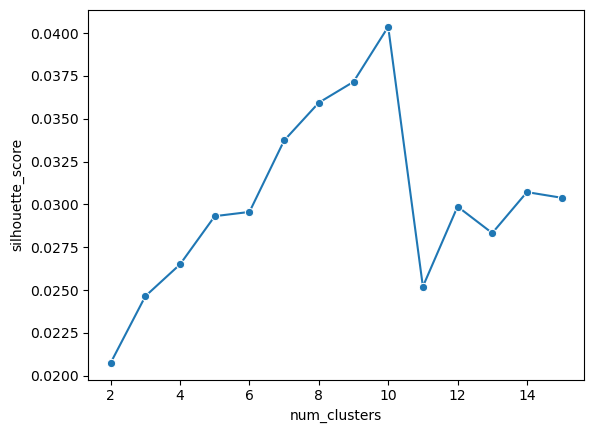

In [123]:
sns.lineplot(data = df_silhouette.reset_index(), x = 'num_clusters', y = 'silhouette_score', marker = 'o');

As suspected, the silhouette scores are quite low regardless of the number of clusters due to the high-dimensionality of the data. A dimensionality reduction technique called latent semantic analysis may help improve the quality of clustering by turning the TF-IDF matrix into a lower dimensional matrix that represents documents as a collection of topics that are discovered based on word groupings present in the documents. The link below leads to a video that provides a good intuitive explanation of how latent semantic analysis works:

https://www.youtube.com/watch?v=M1duqgg8-IM

In [125]:
# Assess how much explained variance changes as n_components increase
explained_variance = []
n_components_list = np.arange(20, 130, 10)

for num_comp in n_components_list:
    lsa = TruncatedSVD(n_components = num_comp, random_state = 1)
    lsa.fit(tf_idf)
    explained_variance.append(lsa.explained_variance_ratio_.sum())

In [126]:
df_lsa = pd.DataFrame(data = {'num_comp': n_components_list, 'expl_var': explained_variance})
df_lsa

,num_comp,expl_var
0,20,0.275844
1,30,0.353583
2,40,0.420483
3,50,0.479709
4,60,0.533850
5,70,0.584957
6,80,0.633149
7,90,0.678046
8,100,0.721210
9,110,0.760722


C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


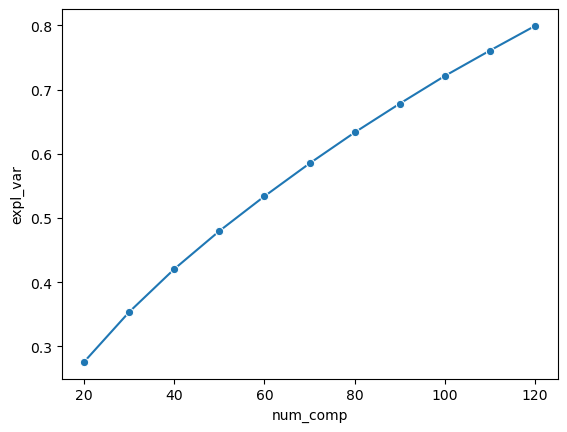

In [127]:
# Plot explained variance over n_components
sns.lineplot(data = df_lsa, x = 'num_comp', y = 'expl_var', marker = 'o');

In the line plot above, there's no clear elbow point that indicates the number of components at which the gain in explained variance begins to decrease. Given that there are about 20 standing committees in each house of Congress, let's use that as a proxy for the number of policy domains that might be represented in the executive actions.

In [129]:
lsa_proxy = TruncatedSVD(n_components = 20, random_state = 1)
doc_topic = lsa_proxy.fit_transform(tf_idf)

In [130]:
# Number of rows = Number of topics
# Number of columns = Number of unique words in the corpus
topic_words = lsa_proxy.components_
topic_words

array([[ 0.00051944,  0.00166668,  0.00470368, ...,  0.00051944,
         0.00580154,  0.00040751],
       [-0.00075827, -0.00205864,  0.01204239, ..., -0.00075827,
         0.00823109, -0.00069634],
       [-0.00112791, -0.00209061, -0.00439476, ..., -0.00112791,
         0.00750734,  0.00010154],
       ...,
       [-0.00134433, -0.00485198,  0.00208419, ..., -0.00134433,
        -0.00760429, -0.0023747 ],
       [-0.000406  , -0.00163706,  0.02147632, ..., -0.000406  ,
         0.01443668, -0.00244417],
       [ 0.00142275,  0.00346834, -0.00224153, ...,  0.00142275,
        -0.00421076,  0.00477107]])

In [131]:
topic_words.shape

(20, 6329)

In [132]:
# Unique words generated by the TF-IDF vectorizer
terms

array(['aaron', 'abandon', 'abate', ..., 'zebley', 'zone', 'zoo'],
      dtype=object)

The dataframe below shows the weight that each word carries in defining a topic.

In [134]:
encoding_matrix = pd.DataFrame(data = np.abs(topic_words),
                               index = [f'topic_{i}' for i in np.arange(1, 21)],
                               columns = terms).T

In [135]:
encoding_matrix

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
aaron,0.000519,0.000758,0.001128,0.000774,0.000019,0.001919,0.001273,0.001615,0.001229,0.001716,0.000710,0.005859,0.003135,0.003742,0.003836,0.001513,0.000706,0.001344,0.000406,0.001423
abandon,0.001667,0.002059,0.002091,0.000846,0.002523,0.004107,0.004050,0.004705,0.000762,0.003520,0.000059,0.011541,0.006363,0.006916,0.006097,0.003025,0.002076,0.004852,0.001637,0.003468
abate,0.004704,0.012042,0.004395,0.001770,0.001276,0.005062,0.007485,0.021477,0.004190,0.000508,0.003145,0.006274,0.007197,0.010173,0.000073,0.009548,0.014623,0.002084,0.021476,0.002242
abele,0.000105,0.000176,0.000048,0.000258,0.000056,0.000268,0.000135,0.000053,0.000351,0.000211,0.000071,0.000105,0.000013,0.000155,0.000505,0.000766,0.000572,0.000541,0.000335,0.001352
abet,0.002520,0.003432,0.004075,0.001429,0.009241,0.004457,0.007851,0.002667,0.002835,0.004394,0.000376,0.004084,0.001465,0.000760,0.010510,0.010210,0.001535,0.005286,0.007404,0.002236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yukon,0.000437,0.000586,0.001741,0.000938,0.000458,0.000468,0.000502,0.000375,0.001468,0.000267,0.001842,0.002433,0.002261,0.002043,0.003452,0.001411,0.000063,0.006072,0.001323,0.001348
zeal,0.000438,0.000271,0.000358,0.000353,0.001391,0.001297,0.000630,0.000612,0.000193,0.000789,0.000675,0.001655,0.002157,0.000607,0.002895,0.000097,0.000932,0.006259,0.000815,0.004352
zebley,0.000519,0.000758,0.001128,0.000774,0.000019,0.001919,0.001273,0.001615,0.001229,0.001716,0.000710,0.005859,0.003135,0.003742,0.003836,0.001513,0.000706,0.001344,0.000406,0.001423
zone,0.005802,0.008231,0.007507,0.001508,0.009566,0.000619,0.006147,0.005553,0.000100,0.011338,0.007502,0.005135,0.004706,0.000517,0.002739,0.010147,0.006920,0.007604,0.014437,0.004211


The printed cell below sorts each topic column to show the top 10 words carrying the most weight. The collection of words provides insight into what the topic is about. For example:

* Topic 2: Trade
* Topic 3: Energy

Note, however, that there seems to be some thematic overlap between several topics. This may be an indication that trying to break up the corpus into 20 topics may be too granular. Let's try reducing the number of topics to 15 to see what happens.

In [137]:
for i in np.arange(1, topic_words.shape[0] + 1):
    print(encoding_matrix.loc[:, f'topic_{i}'].sort_values(ascending = False).head(10))
    print()

order        0.328161
shall        0.263289
united       0.192381
states       0.187676
law          0.170862
secretary    0.166840
agency       0.162593
executive    0.152271
section      0.124429
national     0.118548
Name: topic_1, dtype: float64

duty       0.307513
tariff     0.220864
trade      0.174066
article    0.160664
rate       0.158790
agency     0.144899
valorem    0.138045
ad         0.133651
shall      0.124725
federal    0.123271
Name: topic_2, dtype: float64

energy         0.362480
secretary      0.234464
mineral        0.192423
nuclear        0.191856
period         0.174538
tiktok         0.152165
enforcement    0.147783
reactor        0.147485
order          0.138675
defense        0.130425
Name: topic_3, dtype: float64

period         0.255962
tiktok         0.249155
act            0.236452
energy         0.212122
education      0.189322
adversary      0.179257
foreign        0.170130
application    0.153407
control        0.145133
enforcement    0.138025
Name: t

In [138]:
lsa_proxy = TruncatedSVD(n_components = 15, random_state = 1)
doc_topic = lsa_proxy.fit_transform(tf_idf)
topic_words = lsa_proxy.components_

In [139]:
encoding_matrix = pd.DataFrame(data = np.abs(topic_words),
                               index = [f'topic_{i}' for i in np.arange(1, 16)],
                               columns = terms).T

In [140]:
for i in np.arange(1, topic_words.shape[0] + 1):
    print(encoding_matrix.loc[:, f'topic_{i}'].sort_values(ascending = False).head(10))
    print()

order        0.328161
shall        0.263289
united       0.192381
states       0.187676
law          0.170862
secretary    0.166840
agency       0.162593
executive    0.152271
section      0.124429
national     0.118548
Name: topic_1, dtype: float64

duty       0.307516
tariff     0.220858
trade      0.174062
article    0.160663
rate       0.158785
agency     0.144892
valorem    0.138047
ad         0.133653
shall      0.124728
federal    0.123267
Name: topic_2, dtype: float64

energy         0.361911
secretary      0.234534
mineral        0.193232
nuclear        0.191913
period         0.174707
tiktok         0.152022
enforcement    0.147927
reactor        0.147746
order          0.138303
defense        0.130734
Name: topic_3, dtype: float64

period         0.255707
tiktok         0.249339
act            0.236526
energy         0.213441
education      0.188740
adversary      0.179303
foreign        0.170376
application    0.153539
control        0.145018
enforcement    0.137076
Name: t

Some thematic overlap still remains despite moderate improvements. However, reducing the number of topics too much can undermine differentiating the documents by policy domain. Let's stick with representing documents as 15-topic weight vectors and see if the K-means clustering algorithm can do a better job of grouping executive actions by policy domain.

## Train and evaluate k-means clustering model

### Choosing the number of clusters

Given that the true number of clusters is unknown, let's combine the silhouette score with human judgment to find the optimum number of clusters. The code cell below calculates the silhouette scores for models trained with cluster numbers ranging from 2 to 20. Note that an upperbound of 20 clusters is similar to the number of congressional standing committees that handle different policy domains. Numbers of clusters beyond this upper bound are not considered to avoid potential overfitting, particularly given that there are only 210 executive actions.

In [145]:
# Compute silhouette scores
scores = {}
for num_clusters in range(2, 21):
    k_means = KMeans(n_clusters = num_clusters, n_init = 'auto', random_state = 37)  ## Random state set for replicability
    k_means.fit(doc_topic)
    score = silhouette_score(X = doc_topic, labels = k_means.labels_)
    scores[num_clusters] = score
    print(f'Silhouette score for {num_clusters} clusters: {score:.2f}')

Silhouette score for 2 clusters: 0.34
Silhouette score for 3 clusters: 0.32
Silhouette score for 4 clusters: 0.14
Silhouette score for 5 clusters: 0.15
Silhouette score for 6 clusters: 0.17
Silhouette score for 7 clusters: 0.20
Silhouette score for 8 clusters: 0.21
Silhouette score for 9 clusters: 0.22
Silhouette score for 10 clusters: 0.24
Silhouette score for 11 clusters: 0.26
Silhouette score for 12 clusters: 0.25
Silhouette score for 13 clusters: 0.25
Silhouette score for 14 clusters: 0.27
Silhouette score for 15 clusters: 0.28
Silhouette score for 16 clusters: 0.27
Silhouette score for 17 clusters: 0.30
Silhouette score for 18 clusters: 0.31
Silhouette score for 19 clusters: 0.29
Silhouette score for 20 clusters: 0.29


In [146]:
df_silhouette = pd.DataFrame(data = list(scores.items()),
                             columns = ['num_clusters', 'silhouette_score']
                            )
df_silhouette.set_index(keys = 'num_clusters', inplace = True)
df_silhouette.sort_values(by = 'silhouette_score', ascending = False)

,silhouette_score
num_clusters,
2,0.341594
3,0.319858
18,0.306677
17,0.295021
19,0.294026
20,0.289735
15,0.277129
16,0.273305
14,0.265842


C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


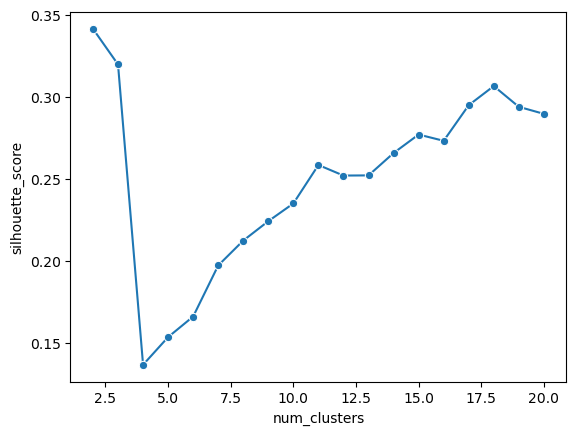

In [147]:
sns.lineplot(data = df_silhouette.reset_index(), x = 'num_clusters', y = 'silhouette_score', marker = 'o');

The highest silhouette score at 2 clusters is disregarded because executive actions span far more policy domains than that. The score is likely high because having only 2 clusters in 15-dimensional space makes documents from different clusters quite far away from one another. Let's select 18 cluster centers, which is the inflection point at which the silhouette score begins to decrease after increasing.

### Cluster assignments

In [150]:
# Train k-means clustering model and obtain cluster assignments (k = 18)
k_means = KMeans(n_clusters = 18, n_init = 10, random_state = 37) ## Random seed for reproducibility
cluster_assignments = k_means.fit_predict(X = doc_topic)

In [151]:
cluster_assignments

array([11, 11,  6,  4, 13, 11,  0, 16,  3,  6,  6,  1, 11, 11,  3,  1, 12,
       16,  1, 17,  1,  6, 10,  3, 11, 17, 11, 11, 13,  7, 13,  1,  1,  3,
       14, 11,  3, 12, 13,  1, 17, 17, 13, 16,  3,  7, 17,  9,  6, 13,  8,
        4,  1,  5, 11,  2,  6,  2,  6, 11, 11,  9, 17,  6, 10, 14,  8,  1,
        3,  6, 11,  1, 13,  1, 11, 15, 14, 11, 17, 11,  1, 11, 11, 15,  9,
       17,  9, 11,  1,  1,  1,  4, 11, 11,  2,  1,  2,  5,  1,  1, 12, 17,
       13,  0, 16,  1,  9, 17, 11,  9,  1, 11,  7,  2,  7, 11,  9,  5,  0,
       11,  8,  1,  3,  4,  4, 11, 15, 17, 11,  1, 11, 13,  6, 15,  6,  6,
       17,  6,  6, 13,  5, 17,  2,  0,  1,  1,  1,  9,  1, 17, 11, 11,  1,
       13,  1, 17, 13,  7,  1,  1,  1, 11,  9, 13, 11, 11, 14, 13, 13, 11,
        7, 17,  6, 11,  1, 11, 11,  6, 11, 12, 12,  6, 16,  1, 11, 11, 10,
        2, 15, 11, 12,  8, 14,  3, 11, 11, 11, 13, 10,  6,  9,  1,  2, 13,
        5, 11,  1, 12,  3,  1])

Append the cluster assignments as a new column in the dataframe.

In [153]:
df_text['cluster'] = cluster_assignments
df_text

,document_number,text,token,cluster
0,2025-05838,<PRESDOCU>\n <EXECORD>\n ...,restore truth sanity american history purpose ...,11
1,2025-02096,<PRESDOCU>\n <EXECORD>\n ...,restore name honor american greatness purpose ...,11
2,2025-13925,<PRESDOCU>\n <EXECORD>\n ...,create schedule g excepted service purpose con...,6
3,2025-15823,<PRESDOCU>\n <EXECORD>\n ...,ensure american pharmaceutical supply chain re...,4
4,2025-11358,<PRESDOCU>\n <EXECORD>\n ...,empower commonsense wildfire prevention respon...,13
...,...,...,...,...
205,2025-16396,<PRESDOCU>\n <EXECORD>\n ...,title president executive order august improve...,11
206,2025-14896,<PRESDOCU>\n <EXECORD>\n ...,address threat united states government brazil...,1
207,2025-07835,<PRESDOCU>\n <EXECORD>\n ...,address certain tariff import article authorit...,12
208,2025-02931,<PRESDOCU>\n <EXECORD>\n ...,keep education accessible end vaccine mandate ...,3


Let's look at the distribution of cluster assignments.

In [155]:
# Turn the cluster assignments into a Pandas series
cluster_series = pd.Series(data = cluster_assignments)
cluster_series

0      11
1      11
2       6
3       4
4      13
       ..
205    11
206     1
207    12
208     3
209     1
Length: 210, dtype: int32

In [156]:
# Compute the number of documents assigned to each cluster
cluster_count = cluster_series.value_counts()
cluster_count = cluster_count.reset_index()
cluster_count

,index,count
0,11,45
1,1,36
2,6,18
3,13,17
4,17,16
5,3,10
6,9,10
7,2,8
8,12,7
9,7,6


In [157]:
# Compute the proportion of documents assigned to each cluster
cluster_pct = cluster_series.value_counts(normalize = True)
cluster_pct = cluster_pct.reset_index()
cluster_pct

,index,proportion
0,11,0.214286
1,1,0.171429
2,6,0.085714
3,13,0.080952
4,17,0.076190
5,3,0.047619
6,9,0.047619
7,2,0.038095
8,12,0.033333
9,7,0.028571


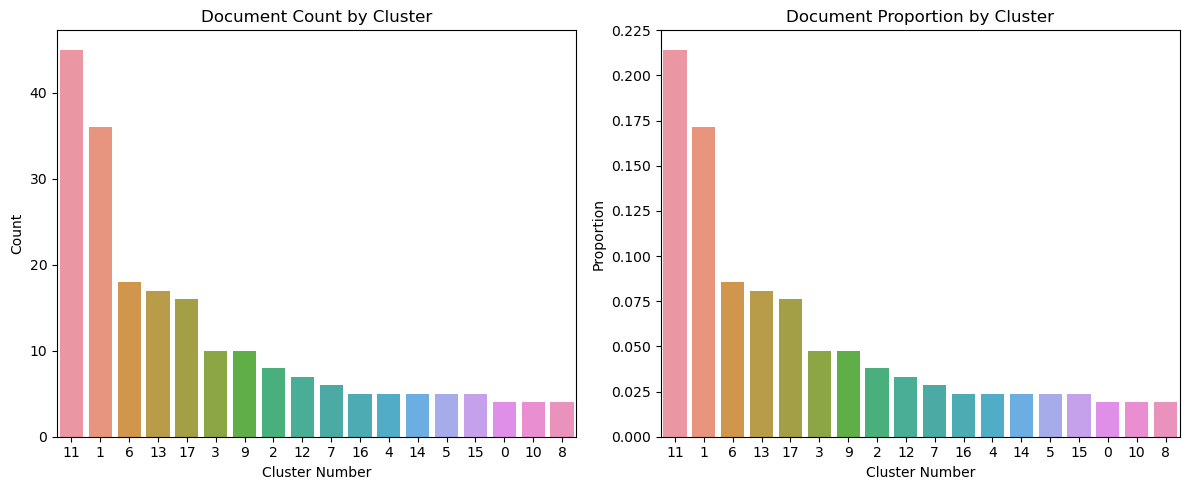

In [158]:
# Instantiate figure and axis objects
fig_cluster_dist, axes_cluster_dist = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

# Frequency plot of documents assigned to each cluster
sns.barplot(data = cluster_count, 
            x = 'index', 
            y = 'count',
            order = cluster_count['index'],
            ax = axes_cluster_dist[0]
           )

# Relative frequency plot of documents assigned to each cluster
sns.barplot(data = cluster_pct, 
            x = 'index', 
            y = 'proportion',
            order = cluster_pct['index'],
            ax = axes_cluster_dist[1]
           )

# Format plot
label_list = ['Count', 'Proportion']
for i in range(len(axes_cluster_dist)):
    axes_cluster_dist[i].set_title(f'Document {label_list[i]} by Cluster')
    axes_cluster_dist[i].set_xlabel('Cluster Number')
    axes_cluster_dist[i].set_ylabel(f'{label_list[i]}')

plt.tight_layout()

### Cluster quality

High-quality clusters should display the following attributes:

*  Documents within the same cluster are similar.
*  Documents from different clusters are not similar.

For each cluster, let's inspect the top 5 documents that are the closest to the cluster center to see if coherent policy domains can be identified.

### Inspect sample documents

Create two more dataframe columns with the following information: 

* Euclidean distance between each document's topic vector and its cluster center topic vector.
* URLs to human-readable text for inspection.

In [163]:
# Function compute Euclidean distance between each document and cluster center
def euclidean_distance(cluster_centers, cluster_assign, doc_topic):
    euc_dist_matrix = pairwise_distances(doc_topic, cluster_centers)
    euc_dist = euc_dist_matrix[np.arange(len(cluster_assign)), cluster_assign]
    
    return euc_dist

In [164]:
# Add Euclidean distance column
df_text['euc_dist'] = euclidean_distance(cluster_centers = k_means.cluster_centers_, 
                                         cluster_assign = cluster_assignments,
                                         doc_topic = doc_topic  ## Toggle depending on whether LSA used or not
                                        )

In [165]:
# Add url column
df_text['html_url'] = df_text['document_number'].apply(lambda doc_num: json_results[doc_num]['html_url'])

In [166]:
df_text

,document_number,text,token,cluster,euc_dist,html_url
0,2025-05838,<PRESDOCU>\n <EXECORD>\n ...,restore truth sanity american history purpose ...,11,0.187121,https://www.federalregister.gov/documents/2025...
1,2025-02096,<PRESDOCU>\n <EXECORD>\n ...,restore name honor american greatness purpose ...,11,0.201807,https://www.federalregister.gov/documents/2025...
2,2025-13925,<PRESDOCU>\n <EXECORD>\n ...,create schedule g excepted service purpose con...,6,0.295556,https://www.federalregister.gov/documents/2025...
3,2025-15823,<PRESDOCU>\n <EXECORD>\n ...,ensure american pharmaceutical supply chain re...,4,0.203540,https://www.federalregister.gov/documents/2025...
4,2025-11358,<PRESDOCU>\n <EXECORD>\n ...,empower commonsense wildfire prevention respon...,13,0.228580,https://www.federalregister.gov/documents/2025...
...,...,...,...,...,...,...
205,2025-16396,<PRESDOCU>\n <EXECORD>\n ...,title president executive order august improve...,11,0.222073,https://www.federalregister.gov/documents/2025...
206,2025-14896,<PRESDOCU>\n <EXECORD>\n ...,address threat united states government brazil...,1,0.367525,https://www.federalregister.gov/documents/2025...
207,2025-07835,<PRESDOCU>\n <EXECORD>\n ...,address certain tariff import article authorit...,12,0.270161,https://www.federalregister.gov/documents/2025...
208,2025-02931,<PRESDOCU>\n <EXECORD>\n ...,keep education accessible end vaccine mandate ...,3,0.178829,https://www.federalregister.gov/documents/2025...


Next, group the dataframe by cluster to retrieve representative sample documents from each cluster that are the closest to the cluster center.

In [168]:
# Group dataframe by cluster assignment
cluster_groups = df_text.groupby(by = 'cluster')

In [169]:
# Inspect top 5 documents closest to the cluster center
top_n = 5

# Display top n closest documents by cluster 
for cluster_num, cluster_data in cluster_groups:
    print(f'Cluster {cluster_num}:')
    print()
    cluster_data['html_url'] = cluster_data['html_url'].apply(
        lambda url: f'<a href = "{url}" target = "_blank">Link</a>'
    )
    display(HTML(
        cluster_data.sort_values(by = 'euc_dist')[['document_number', 'cluster', 'euc_dist', 'html_url']]
        .head(top_n)
        .to_html(render_links = True, escape = False)
    ))    
    print()

Cluster 0:



,document_number,cluster,euc_dist,html_url
103,2025-15550,0,0.087706,Link
118,2025-16614,0,0.109905,Link
143,2025-16615,0,0.112875,Link
6,2025-05837,0,0.147847,Link



Cluster 1:



,document_number,cluster,euc_dist,html_url
31,2025-05908,1,0.130792,Link
152,2025-12506,1,0.132767,Link
209,2025-02103,1,0.133986,Link
174,2025-19483,1,0.137626,Link
73,2025-02504,1,0.149166,Link



Cluster 2:



,document_number,cluster,euc_dist,html_url
55,2025-02408,2,0.147563,Link
142,2025-02407,2,0.162400,Link
113,2025-14999,2,0.163333,Link
57,2025-02406,2,0.163786,Link
202,2025-02478,2,0.173416,Link



Cluster 3:



,document_number,cluster,euc_dist,html_url
33,2025-07377,3,0.115702,Link
36,2025-07376,3,0.116950,Link
208,2025-02931,3,0.178829,Link
23,2025-05213,3,0.185179,Link
14,2025-02090,3,0.199717,Link



Cluster 4:



,document_number,cluster,euc_dist,html_url
91,2025-03440,4,0.127616,Link
123,2025-06837,4,0.193282,Link
124,2025-08876,4,0.198809,Link
3,2025-15823,4,0.203540,Link
51,2025-08267,4,0.235940,Link



Cluster 5:



,document_number,cluster,euc_dist,html_url
53,2025-02087,5,0.076802,Link
140,2025-06162,5,0.101328,Link
97,2025-18482,5,0.104755,Link
204,2025-11682,5,0.111723,Link
117,2025-19139,5,0.253613,Link



Cluster 6:



,document_number,cluster,euc_dist,html_url
69,2025-02734,6,0.121559,Link
137,2025-02175,6,0.132652,Link
56,2025-19485,6,0.176197,Link
199,2025-04868,6,0.185568,Link
138,2025-16924,6,0.188955,Link



Cluster 7:



,document_number,cluster,euc_dist,html_url
29,2025-05845,7,0.072735,Link
114,2025-05519,7,0.084344,Link
112,2025-06458,7,0.121871,Link
45,2025-03989,7,0.125775,Link
157,2025-04867,7,0.196973,Link



Cluster 8:



,document_number,cluster,euc_dist,html_url
50,2025-09801,8,0.108186,Link
120,2025-09799,8,0.108830,Link
66,2025-09798,8,0.173655,Link
191,2025-09796,8,0.187408,Link



Cluster 9:



,document_number,cluster,euc_dist,html_url
61,2025-15010,9,0.100330,Link
147,2025-15554,9,0.105737,Link
116,2025-12962,9,0.143467,Link
106,2025-06462,9,0.167062,Link
200,2025-06378,9,0.167242,Link



Cluster 10:



,document_number,cluster,euc_dist,html_url
22,2025-02231,10,0.086040,Link
198,2025-15193,10,0.119903,Link
64,2025-04102,10,0.124149,Link
186,2025-02611,10,0.273377,Link



Cluster 11:



,document_number,cluster,euc_dist,html_url
195,2025-08133,11,0.109666,Link
194,2025-05906,11,0.128175,Link
59,2025-07786,11,0.140964,Link
164,2025-08683,11,0.142219,Link
189,2025-02735,11,0.148562,Link



Cluster 12:



,document_number,cluster,euc_dist,html_url
190,2025-14897,12,0.140150,Link
179,2025-02512,12,0.221292,Link
100,2025-03775,12,0.239353,Link
37,2025-06027,12,0.248502,Link
180,2025-03729,12,0.259220,Link



Cluster 13:



,document_number,cluster,euc_dist,html_url
131,2025-06380,13,0.151014,Link
163,2025-12961,13,0.158776,Link
197,2025-01955,13,0.172503,Link
30,2025-03695,13,0.176566,Link
49,2025-05212,13,0.185005,Link



Cluster 14:



,document_number,cluster,euc_dist,html_url
192,2025-05522,14,0.104977,Link
76,2025-03992,14,0.122825,Link
166,2025-02123,14,0.127245,Link
65,2025-05524,14,0.144021,Link
34,2025-15340,14,0.156013,Link



Cluster 15:



,document_number,cluster,euc_dist,html_url
126,2025-02006,15,0.138790,Link
188,2025-07789,15,0.142331,Link
75,2025-02009,15,0.165929,Link
133,2025-02015,15,0.169718,Link
83,2025-03137,15,0.246943,Link



Cluster 16:



,document_number,cluster,euc_dist,html_url
17,2025-14217,16,0.156839,Link
43,2025-19495,16,0.161307,Link
7,2025-14218,16,0.191414,Link
182,2025-02172,16,0.245612,Link
104,2025-07368,16,0.277994,Link



Cluster 17:



,document_number,cluster,euc_dist,html_url
127,2025-03063,17,0.122290,Link
46,2025-08682,17,0.133572,Link
41,2025-06463,17,0.135970,Link
101,2025-02345,17,0.139129,Link
85,2025-05197,17,0.177749,Link


Based on document inspection, the clusters seem to have the following policy domain distribution:

* Cluster 0: Law enforcement
* Cluster 1: Foreign policy
* Cluster 2: Drug enforcement
* Cluster 3: Education
* Cluster 4: Public health (pharmaceutical access)
* Cluster 5: TikTok enforcement
* Cluster 6: Government agencies
* Cluster 7: Punitive measures for politically opposed law firms
* Cluster 8: Nuclear energy
* Cluster 9: Tariffs
* Cluster 10: Special task force
* Cluster 11: Cultural ideology
* Cluster 12: Drug enforcement
* Cluster 13: Energy and natural resources
* Cluster 14: Financial regulations
* Cluster 15: Immigration policy
* Cluster 16: Artificial intelligence
* Cluster 17: Government agencies

There is some overlap in the policy domain covered by multiple clusters (e.g., clusters 6 and 17 covering government agencies). Let's try reducing the number of clusters to see if overlapping clusters merge into one.

### Re-train with 15 clusters

In [172]:
# Train k-means clustering model and obtain cluster assignments (k = 18)
k_means = KMeans(n_clusters = 15, n_init = 10, random_state = 37) ## Random seed for reproducibility
cluster_assignments = k_means.fit_predict(X = doc_topic)

In [173]:
cluster_assignments

array([ 7,  7,  7, 13,  1,  7,  0,  4, 11,  7,  7,  9,  7,  3, 11,  9,  2,
        4,  9,  3,  9,  7,  8, 11,  7,  3,  7, 11,  1, 10,  1,  9,  9, 11,
        9, 11, 11,  2,  1,  9,  3,  3,  1,  4, 11, 10,  3,  5,  7,  1, 12,
       13,  9,  6,  7,  2,  7,  2,  7,  7, 11,  5,  3,  7,  8,  3, 12,  9,
       11,  7, 11,  9,  1,  9,  7, 14,  9, 14,  3,  7,  9, 11,  9, 14,  5,
        3,  5,  7,  9,  9,  9, 13,  7,  7,  2,  9,  2,  6,  7,  9,  2,  3,
        1,  0,  4,  9,  5,  3,  7,  5,  9,  7, 10,  2, 10,  7,  5,  6,  0,
        7, 12,  9, 11, 13, 13,  7, 14,  3,  7,  9,  7,  1,  7, 14,  7,  7,
        3,  7,  7,  1,  6,  3,  2,  0,  9,  9,  9,  5,  9,  7,  7,  7,  9,
        1,  9,  3,  1, 10,  9,  5,  9,  7,  5,  1,  7,  7,  9,  1,  1,  7,
       10,  3,  7,  9,  9,  7,  7,  7,  9,  2,  2,  7,  4,  9,  7,  7,  8,
        2, 14,  7,  2, 12,  3, 11,  7,  7,  7,  1,  8,  7,  5,  9,  2,  1,
        6,  7,  5,  2, 11,  9])

In [174]:
df_text['cluster'] = cluster_assignments
df_text

,document_number,text,token,cluster,euc_dist,html_url
0,2025-05838,<PRESDOCU>\n <EXECORD>\n ...,restore truth sanity american history purpose ...,7,0.187121,https://www.federalregister.gov/documents/2025...
1,2025-02096,<PRESDOCU>\n <EXECORD>\n ...,restore name honor american greatness purpose ...,7,0.201807,https://www.federalregister.gov/documents/2025...
2,2025-13925,<PRESDOCU>\n <EXECORD>\n ...,create schedule g excepted service purpose con...,7,0.295556,https://www.federalregister.gov/documents/2025...
3,2025-15823,<PRESDOCU>\n <EXECORD>\n ...,ensure american pharmaceutical supply chain re...,13,0.203540,https://www.federalregister.gov/documents/2025...
4,2025-11358,<PRESDOCU>\n <EXECORD>\n ...,empower commonsense wildfire prevention respon...,1,0.228580,https://www.federalregister.gov/documents/2025...
...,...,...,...,...,...,...
205,2025-16396,<PRESDOCU>\n <EXECORD>\n ...,title president executive order august improve...,7,0.222073,https://www.federalregister.gov/documents/2025...
206,2025-14896,<PRESDOCU>\n <EXECORD>\n ...,address threat united states government brazil...,5,0.367525,https://www.federalregister.gov/documents/2025...
207,2025-07835,<PRESDOCU>\n <EXECORD>\n ...,address certain tariff import article authorit...,2,0.270161,https://www.federalregister.gov/documents/2025...
208,2025-02931,<PRESDOCU>\n <EXECORD>\n ...,keep education accessible end vaccine mandate ...,11,0.178829,https://www.federalregister.gov/documents/2025...


In [175]:
# Turn the cluster assignments into a Pandas series
cluster_series = pd.Series(data = cluster_assignments)
cluster_series

0       7
1       7
2       7
3      13
4       1
       ..
205     7
206     5
207     2
208    11
209     9
Length: 210, dtype: int32

In [176]:
# Compute the number of documents assigned to each cluster
cluster_count = cluster_series.value_counts()
cluster_count = cluster_count.reset_index()
cluster_count

,index,count
0,7,55
1,9,39
2,3,18
3,1,17
4,11,15
5,2,15
6,5,12
7,10,6
8,14,6
9,13,5


In [177]:
# Compute the proportion of documents assigned to each cluster
cluster_pct = cluster_series.value_counts(normalize = True)
cluster_pct = cluster_pct.reset_index()
cluster_pct

,index,proportion
0,7,0.261905
1,9,0.185714
2,3,0.085714
3,1,0.080952
4,11,0.071429
5,2,0.071429
6,5,0.057143
7,10,0.028571
8,14,0.028571
9,13,0.023810


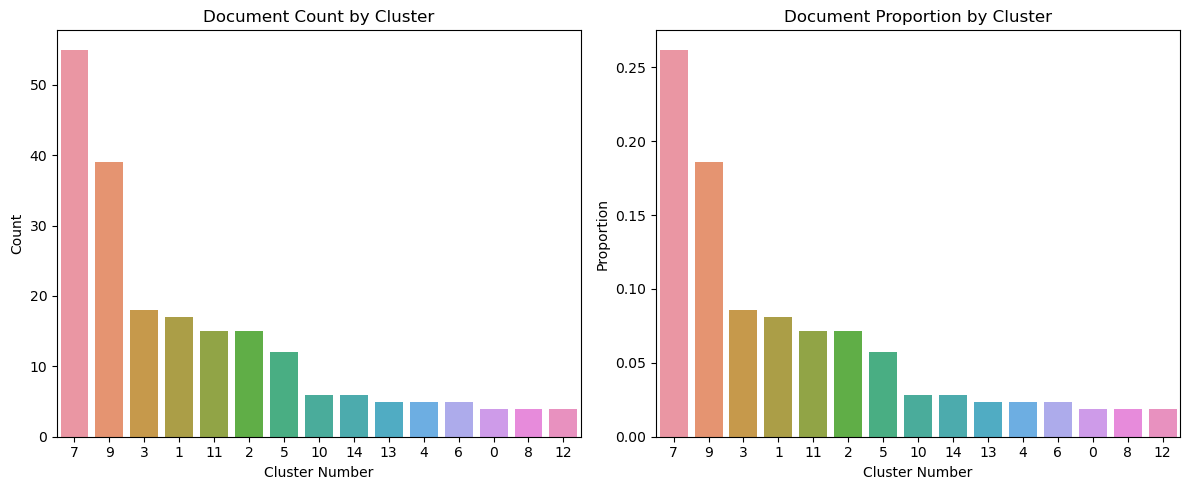

In [178]:
# Instantiate figure and axis objects
fig_cluster_dist, axes_cluster_dist = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

# Frequency plot of documents assigned to each cluster
sns.barplot(data = cluster_count, 
            x = 'index', 
            y = 'count',
            order = cluster_count['index'],
            ax = axes_cluster_dist[0]
           )

# Relative frequency plot of documents assigned to each cluster
sns.barplot(data = cluster_pct, 
            x = 'index', 
            y = 'proportion',
            order = cluster_pct['index'],
            ax = axes_cluster_dist[1]
           )

# Format plot
label_list = ['Count', 'Proportion']
for i in range(len(axes_cluster_dist)):
    axes_cluster_dist[i].set_title(f'Document {label_list[i]} by Cluster')
    axes_cluster_dist[i].set_xlabel('Cluster Number')
    axes_cluster_dist[i].set_ylabel(f'{label_list[i]}')

plt.tight_layout()

Note that the new cluster numbers do not align with those from the first iteration of the model. Inspect sample documents from each cluster for policy domain identification.

In [180]:
# Add Euclidean distance column
df_text['euc_dist'] = euclidean_distance(cluster_centers = k_means.cluster_centers_, 
                                         cluster_assign = cluster_assignments,
                                         doc_topic = doc_topic  ## Toggle depending on whether LSA used or not
                                        )

In [181]:
# Add url column
df_text['html_url'] = df_text['document_number'].apply(lambda doc_num: json_results[doc_num]['html_url'])

In [182]:
df_text

,document_number,text,token,cluster,euc_dist,html_url
0,2025-05838,<PRESDOCU>\n <EXECORD>\n ...,restore truth sanity american history purpose ...,7,0.211662,https://www.federalregister.gov/documents/2025...
1,2025-02096,<PRESDOCU>\n <EXECORD>\n ...,restore name honor american greatness purpose ...,7,0.218414,https://www.federalregister.gov/documents/2025...
2,2025-13925,<PRESDOCU>\n <EXECORD>\n ...,create schedule g excepted service purpose con...,7,0.285412,https://www.federalregister.gov/documents/2025...
3,2025-15823,<PRESDOCU>\n <EXECORD>\n ...,ensure american pharmaceutical supply chain re...,13,0.203540,https://www.federalregister.gov/documents/2025...
4,2025-11358,<PRESDOCU>\n <EXECORD>\n ...,empower commonsense wildfire prevention respon...,1,0.228580,https://www.federalregister.gov/documents/2025...
...,...,...,...,...,...,...
205,2025-16396,<PRESDOCU>\n <EXECORD>\n ...,title president executive order august improve...,7,0.216883,https://www.federalregister.gov/documents/2025...
206,2025-14896,<PRESDOCU>\n <EXECORD>\n ...,address threat united states government brazil...,5,0.324908,https://www.federalregister.gov/documents/2025...
207,2025-07835,<PRESDOCU>\n <EXECORD>\n ...,address certain tariff import article authorit...,2,0.181353,https://www.federalregister.gov/documents/2025...
208,2025-02931,<PRESDOCU>\n <EXECORD>\n ...,keep education accessible end vaccine mandate ...,11,0.234282,https://www.federalregister.gov/documents/2025...


In [183]:
# Group dataframe by cluster assignment
cluster_groups = df_text.groupby(by = 'cluster')

In [184]:
# Inspect top 5 documents closest to the cluster center
top_n = 5

# Display top n closest documents by cluster 
for cluster_num, cluster_data in cluster_groups:
    print(f'Cluster {cluster_num}:')
    print()
    cluster_data['html_url'] = cluster_data['html_url'].apply(
        lambda url: f'<a href = "{url}" target = "_blank">Link</a>'
    )
    display(HTML(
        cluster_data.sort_values(by = 'euc_dist')[['document_number', 'cluster', 'euc_dist', 'html_url']]
        .head(top_n)
        .to_html(render_links = True, escape = False)
    ))    
    print()

Cluster 0:



,document_number,cluster,euc_dist,html_url
103,2025-15550,0,0.087706,Link
118,2025-16614,0,0.109905,Link
143,2025-16615,0,0.112875,Link
6,2025-05837,0,0.147847,Link



Cluster 1:



,document_number,cluster,euc_dist,html_url
131,2025-06380,1,0.151014,Link
163,2025-12961,1,0.158776,Link
197,2025-01955,1,0.172503,Link
30,2025-03695,1,0.176566,Link
49,2025-05212,1,0.185005,Link



Cluster 2:



,document_number,cluster,euc_dist,html_url
96,2025-03990,2,0.134631,Link
94,2025-03991,2,0.146788,Link
100,2025-03775,2,0.173595,Link
207,2025-07835,2,0.181353,Link
55,2025-02408,2,0.242473,Link



Cluster 3:



,document_number,cluster,euc_dist,html_url
46,2025-08682,3,0.144292,Link
41,2025-06463,3,0.150449,Link
62,2025-05214,3,0.159526,Link
127,2025-03063,3,0.160507,Link
101,2025-02345,3,0.161010,Link



Cluster 4:



,document_number,cluster,euc_dist,html_url
17,2025-14217,4,0.156839,Link
43,2025-19495,4,0.161307,Link
7,2025-14218,4,0.191414,Link
182,2025-02172,4,0.245612,Link
104,2025-07368,4,0.277994,Link



Cluster 5:



,document_number,cluster,euc_dist,html_url
61,2025-15010,5,0.135755,Link
147,2025-15554,5,0.154484,Link
109,2025-17507,5,0.168510,Link
116,2025-12962,5,0.188106,Link
86,2025-06063,5,0.197907,Link



Cluster 6:



,document_number,cluster,euc_dist,html_url
53,2025-02087,6,0.076802,Link
140,2025-06162,6,0.101328,Link
97,2025-18482,6,0.104755,Link
204,2025-11682,6,0.111723,Link
117,2025-19139,6,0.253613,Link



Cluster 7:



,document_number,cluster,euc_dist,html_url
92,2025-02636,7,0.100982,Link
59,2025-07786,7,0.133472,Link
12,2025-03694,7,0.136926,Link
125,2025-01902,7,0.140750,Link
195,2025-08133,7,0.151151,Link



Cluster 8:



,document_number,cluster,euc_dist,html_url
22,2025-02231,8,0.086040,Link
198,2025-15193,8,0.119903,Link
64,2025-04102,8,0.124149,Link
186,2025-02611,8,0.273377,Link



Cluster 9:



,document_number,cluster,euc_dist,html_url
31,2025-05908,9,0.109362,Link
209,2025-02103,9,0.118628,Link
152,2025-12506,9,0.140001,Link
174,2025-19483,9,0.141958,Link
105,2025-02477,9,0.148794,Link



Cluster 10:



,document_number,cluster,euc_dist,html_url
29,2025-05845,10,0.072735,Link
114,2025-05519,10,0.084344,Link
112,2025-06458,10,0.121871,Link
45,2025-03989,10,0.125775,Link
157,2025-04867,10,0.196973,Link



Cluster 11:



,document_number,cluster,euc_dist,html_url
36,2025-07376,11,0.126970,Link
33,2025-07377,11,0.131316,Link
14,2025-02090,11,0.173900,Link
44,2025-02513,11,0.188227,Link
81,2025-07380,11,0.194352,Link



Cluster 12:



,document_number,cluster,euc_dist,html_url
50,2025-09801,12,0.108186,Link
120,2025-09799,12,0.108830,Link
66,2025-09798,12,0.173655,Link
191,2025-09796,12,0.187408,Link



Cluster 13:



,document_number,cluster,euc_dist,html_url
91,2025-03440,13,0.127616,Link
123,2025-06837,13,0.193282,Link
124,2025-08876,13,0.198809,Link
3,2025-15823,13,0.203540,Link
51,2025-08267,13,0.235940,Link



Cluster 14:



,document_number,cluster,euc_dist,html_url
188,2025-07789,14,0.114956,Link
126,2025-02006,14,0.169505,Link
75,2025-02009,14,0.204027,Link
83,2025-03137,14,0.220684,Link
133,2025-02015,14,0.220887,Link


Based on document inspection, the clusters seem to have the following policy domain distribution:

* Cluster 0: Law enforcement
* Cluster 1: Energy and natural resources
* Cluster 2: Drug enforcement
* Cluster 3: Government agencies
* Cluster 4: Artificial intelligence
* Cluster 5: Tariffs
* Cluster 6: TikTok enforcement
* Cluster 7: Cultural ideology
* Cluster 8: Special task force
* Cluster 9: Foreign policy
* Cluster 10: Punitive measures for politically opposed law firms
* Cluster 11: Education
* Cluster 12: Nuclear energy
* Cluster 13: Public health (pharmaceutical access)
* Cluster 14: Immigration policy

Clusters now appear well-differentiated by policy domain. Let's add cluster descriptions next to the cluster numbers.

In [186]:
cluster_map = {0: 'Law enforcement',
               1: 'Energy and natural resources',
               2: 'Drug enforcement',
               3: 'Government agencies',
               4: 'Artificial intelligence',
               5: 'Tariffs',
               6: 'TikTok enforcement',
               7: 'Ideology',
               8: 'Special task force',
               9: 'Foreign policy',
               10: 'Punitive measures for politically opposed law firms',
               11: 'Education',
               12: 'Nuclear energy',
               13: 'Public health (pharmaceutical access)',
               14: 'Immigration policy'
              }

In [187]:
cluster_count['cluster_descr'] = cluster_count['index'].map(cluster_map)
cluster_count = cluster_count.reindex(columns = ['index', 'cluster_descr', 'count'])
cluster_count

,index,cluster_descr,count
0,7,Ideology,55
1,9,Foreign policy,39
2,3,Government agencies,18
3,1,Energy and natural resources,17
4,11,Education,15
5,2,Drug enforcement,15
6,5,Tariffs,12
7,10,Punitive measures for politically opposed law ...,6
8,14,Immigration policy,6
9,13,Public health (pharmaceutical access),5


In [188]:
cluster_pct['cluster_descr'] = cluster_pct['index'].map(cluster_map)
cluster_pct = cluster_pct.reindex(columns = ['index', 'cluster_descr', 'proportion'])
cluster_pct

,index,cluster_descr,proportion
0,7,Ideology,0.261905
1,9,Foreign policy,0.185714
2,3,Government agencies,0.085714
3,1,Energy and natural resources,0.080952
4,11,Education,0.071429
5,2,Drug enforcement,0.071429
6,5,Tariffs,0.057143
7,10,Punitive measures for politically opposed law ...,0.028571
8,14,Immigration policy,0.028571
9,13,Public health (pharmaceutical access),0.023810


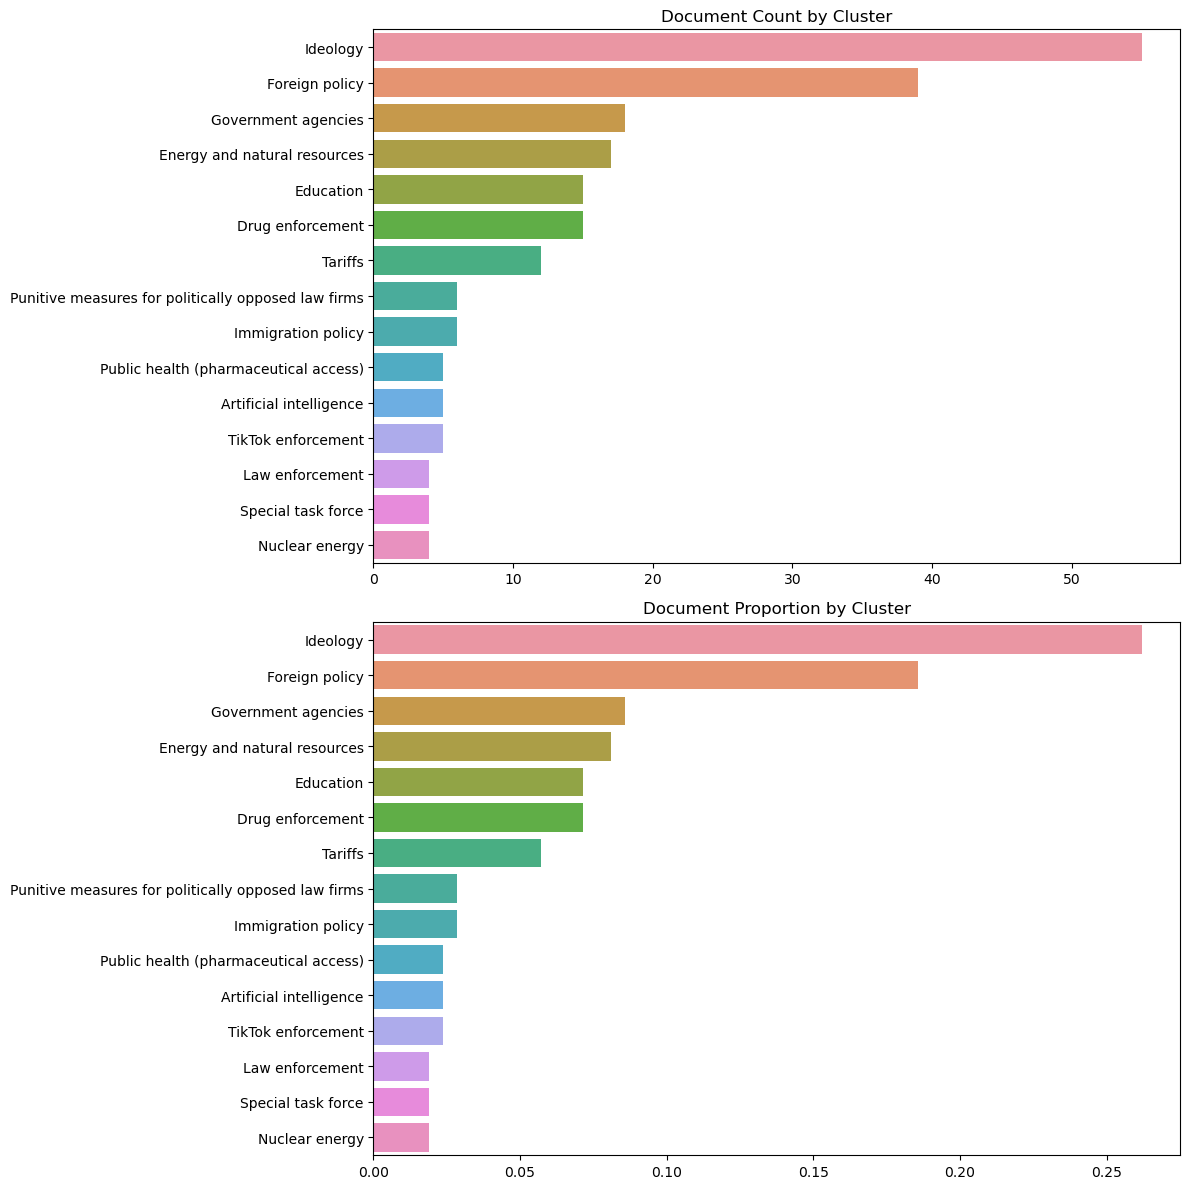

In [189]:
# Instantiate figure and axis objects
fig_cluster_name, axes_cluster_name = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 12))

# Frequency plot of documents assigned to each cluster
sns.barplot(data = cluster_count, 
            x = 'count', 
            y = 'cluster_descr',
            order = cluster_count['cluster_descr'],
            ax = axes_cluster_name[0]
           )

# Relative frequency plot of documents assigned to each cluster
sns.barplot(data = cluster_pct, 
            x = 'proportion', 
            y = 'cluster_descr',
            order = cluster_pct['cluster_descr'],
            ax = axes_cluster_name[1]
           )

# Format plot
label_list = ['Count', 'Proportion']
for i in range(len(axes_cluster_name)):
    axes_cluster_name[i].set_title(f'Document {label_list[i]} by Cluster')
    axes_cluster_name[i].set_xlabel('')
    axes_cluster_name[i].set_ylabel('')

plt.tight_layout()